# ATLAS OmniFold - Stress Test C
In this notebook, we use two Monte Carlo Simulation samples to perform a stress test by treating one as simulation (synthetic data with both particle-level and detector-level information) and one as "data" (real collider data with only detector-level information). We unfold various distributions from "data" and compare it to the associated particle-level information because "data" is also a Monte Carlo simulation.

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
import scipy.stats as stats
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

/global/home/users/adisurtya/anaconda3/envs/omnifold_gpu/lib/python3.7/site-packages/energyflow/emd.py:915: UserWarning: emd module requires 'wasserstein' or 'pot', both of which are unavailable
  warnings.warn(message)


In [4]:
plot_setup()

In [5]:
# Global plot settings
import matplotlib.font_manager
plt.rcParams.update({
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 22,
    "xtick.labelsize": 15, 
    "ytick.labelsize": 15, 
    "legend.fontsize":15
})

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

### Utilities

In [7]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [8]:
# Binary crossentropy for classifying two samples with weights
# Weights are "hidden" by zipping in y_true (the labels)


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1)  # event weights
    y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [9]:
# z-score standardization of data

def standardize(sim_truth, sim_reco, data_reco):
    scaler_truth = preprocessing.StandardScaler()
    scaler_reco = preprocessing.StandardScaler()

    scaler_truth.fit(sim_truth.reshape(-1, 1))
    scaler_reco.fit(np.concatenate((sim_reco, data_reco)).reshape(-1, 1))

    sim_truth_z = np.squeeze(scaler_truth.transform(sim_truth.reshape(-1, 1)))
    sim_reco_z = np.squeeze(scaler_reco.transform(sim_reco.reshape(-1, 1)))
    data_reco_z = np.squeeze(scaler_reco.transform(data_reco.reshape(-1, 1)))

    return sim_truth_z, sim_reco_z, data_reco_z

In [10]:
plot_dir = './SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTestC/'

In [11]:
save_label0 = 'ATLASOmniFold-StressTestC'

### Load ROOT files

#### Simulation (Powheg + Pythia 8 MC16e)

In [12]:
data_dir = '/clusterfs/ml4hep/bpnachman/OmniFoldATLAS/SlimMarch26/'

In [13]:
zmumu_sim = uproot.open(
    data_dir +
    "ZjetOmnifold_Feb20_MCFix_PowhegPythia_mc16e_slim.root")['OmniTree']

In [14]:
zmumu_sim.show()

weight                     (no streamer)              asdtype('>f4')
pass190                    (no streamer)              asdtype('>i4')
truth_pass190              (no streamer)              asdtype('>i4')
weight_mc                  (no streamer)              asdtype('>f4')
prw                        (no streamer)              asdtype('>f4')
pT_ll                      (no streamer)              asdtype('>f4')
pT_l1                      (no streamer)              asdtype('>f4')
pT_l2                      (no streamer)              asdtype('>f4')
eta_l1                     (no streamer)              asdtype('>f4')
eta_l2                     (no streamer)              asdtype('>f4')
phi_l1                     (no streamer)              asdtype('>f4')
phi_l2                     (no streamer)              asdtype('>f4')
y_ll                       (no streamer)              asdtype('>f4')
pT_trackj1                 (no streamer)              asdtype('>f4')
y_trackj1                  (no str

In [15]:
mybranches_sim = []
for mykey in zmumu_sim.keys():
    mybranches_sim += [mykey.decode("utf-8")]

In [16]:
Events_sim = prepare_dataset_table(
    [data_dir + "ZjetOmnifold_Feb20_MCFix_PowhegPythia_mc16e_slim.root"],
    "OmniTree",
    branch_list=mybranches_sim,
    col_names=mybranches_sim,
    entrysteps=10000000,
    outputype=Event_table)

Total number of events:  416725
Events in returned Object:  416725
Loading the data took  8.039472341537476  seconds


#### "Data" (Sherpa 2.2.1 MC16e)

In [17]:
data_files = [
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_0_70_BFilter_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_0_70_CFilterBVeto_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_0_70_CVetoBVeto_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_1000_E_CMS_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_140_280_BFilter_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_140_280_CFilterBVeto_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_140_280_CVetoBVeto_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_280_500_BFilter_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_280_500_CFilterBVeto_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_280_500_CVetoBVeto_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_500_1000_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_70_140_BFilter_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_70_140_CFilterBVeto_slim.root',
    'ZjetOmnifold_Feb20_MCFix_Sherpa221_mc16e_70_140_CVetoBVeto_slim.root'
]

In [18]:
for i in range(len(data_files)):
    data_files[i] = data_dir + data_files[i]

In [19]:
zmumu_data = uproot.open(
    data_files[0])['OmniTree']

In [20]:
zmumu_data.show()

weight                     (no streamer)              asdtype('>f4')
pass190                    (no streamer)              asdtype('>i4')
truth_pass190              (no streamer)              asdtype('>i4')
weight_mc                  (no streamer)              asdtype('>f4')
prw                        (no streamer)              asdtype('>f4')
pT_ll                      (no streamer)              asdtype('>f4')
pT_l1                      (no streamer)              asdtype('>f4')
pT_l2                      (no streamer)              asdtype('>f4')
eta_l1                     (no streamer)              asdtype('>f4')
eta_l2                     (no streamer)              asdtype('>f4')
phi_l1                     (no streamer)              asdtype('>f4')
phi_l2                     (no streamer)              asdtype('>f4')
y_ll                       (no streamer)              asdtype('>f4')
pT_trackj1                 (no streamer)              asdtype('>f4')
y_trackj1                  (no str

In [21]:
mybranches_data = []
for mykey in zmumu_data.keys():
    mybranches_data += [mykey.decode("utf-8")]

In [22]:
Events_data = prepare_dataset_table(
    data_files,
    "OmniTree",
    branch_list=mybranches_data,
    col_names=mybranches_data,
    entrysteps=10000000,
    outputype=Event_table)

Total number of events:  3210042
Events in returned Object:  3210042
Loading the data took  66.79976487159729  seconds


### Unpack data

In [23]:
# Event selection

# we should eventually properly account for events that fail one of MC Truth or MC Reco - for now, just ignore them.

mypass_sim = (Events_sim.events['pass190'].astype(bool)
            ) & Events_sim.events['truth_pass190'].astype(bool) & (np.abs(
                Events_sim.events['truth_y_trackj1']) < 2.1) & (np.abs(
                    Events_sim.events['y_trackj1']) < 2.1) & (np.abs(
                        Events_sim.events['truth_y_trackj2']) < 2.1) & (np.abs(
                            Events_sim.events['y_trackj2']) < 2.1) & (
                                Events_sim.events['m_trackj1'] !=
                                -99) & (Events_sim.events['m_trackj2'] != -99)

In [24]:
mypass_data = (Events_data.events['pass190'].astype(bool)
            ) & Events_data.events['truth_pass190'].astype(bool) & (np.abs(
                Events_data.events['truth_y_trackj1']) < 2.1) & (np.abs(
                    Events_data.events['y_trackj1']) < 2.1) & (np.abs(
                        Events_data.events['truth_y_trackj2']) < 2.1) & (np.abs(
                            Events_data.events['y_trackj2']) < 2.1) & (
                                Events_data.events['m_trackj1'] !=
                                -99) & (Events_data.events['m_trackj2'] != -99)

In [25]:
# Load Monte Carlo Event Weights
sim_weights_MC = Events_sim.events['weight'][mypass_sim]
data_weights_MC = Events_data.events['weight'][mypass_data]

# standardize
sim_weights_MC = sim_weights_MC / np.mean(sim_weights_MC)
data_weights_MC = data_weights_MC / np.mean(data_weights_MC)

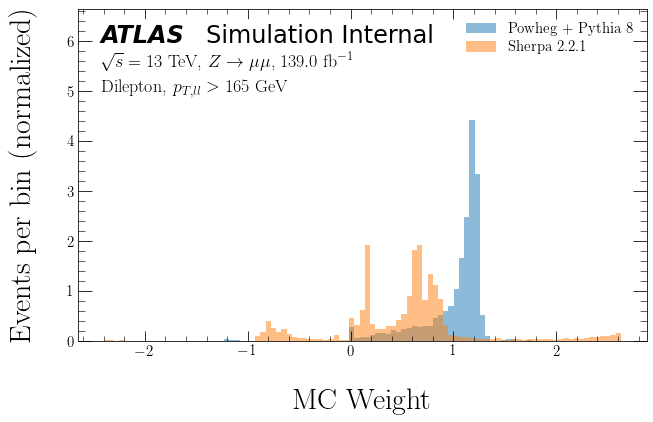

In [26]:
plt.figure(figsize=(10, 6))
bins = np.linspace(np.min(sim_weights_MC), np.max(sim_weights_MC), 100)

hW_sim, _, _ = plt.hist(sim_weights_MC, bins=bins, label=r'Powheg + Pythia 8', **plot_style_2)
hW_data, _, _ = plt.hist(data_weights_MC, bins=bins, label=r'Sherpa 2.2.1', **plot_style_2)
plt.xlabel('MC Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top = 1.5*np.max((hW_sim, hW_data)))
plt.legend()
draw_atlas_text()
plt.show()

In [27]:
file_labels = [
    'm_trackj1', 'm_trackj2', 'Ntracks_trackj1', 'Ntracks_trackj2',
    'tau1_trackj1', 'tau1_trackj2', 'pT_trackj1', 'pT_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'y_trackj1', 'y_trackj2', 'tau3_trackj1', 'tau3_trackj2',
    'pT_ll', 'y_ll'
]

plot_labels = [
    '$m_{j_1}$ [GeV]', '$m_{j_2}$ [GeV]', '$N_{j_1}$', '$N_{j_2}$',
    '$\tau_{1,j_1}$', '$\tau_{1,j_2}$', '$p_{T,j_1}$ [GeV]',
    '$p_{T,j_2}$ [GeV]', '$\tau_{2,j_1}$', '$\tau_{2,j_2}$', '$y_{j_1}$',
    '$y_{j_2}$', '$\tau_{3,j_1}$', '$\tau_{3,j_2}$', '$p_{T,ll}$ [GeV]',
    '$y_{ll}$'
]

bins = [
    np.linspace(0, 50, 21),
    np.linspace(0, 25, 21),
    np.linspace(0, 40, 21),
    np.linspace(0, 40, 21),
    np.linspace(0, 1, 21),
    np.linspace(0, 1, 21),
    np.linspace(0, 500, 21),
    np.linspace(0, 200, 21),
    np.linspace(0, 0.5, 21),
    np.linspace(0, 0.5, 21),
    np.linspace(-4, 4, 21),
    np.linspace(-7.5, 7.5, 21),
    np.linspace(0, 0.4, 21),
    np.linspace(0, 0.4, 21),
    np.linspace(190, 590, 21),
    np.linspace(-3, 3, 21)
]

In [28]:
labels_and_bins = zip(file_labels, plot_labels, bins)

obs = []

for file_label, plot_label, plot_bins in labels_and_bins:
    obs += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

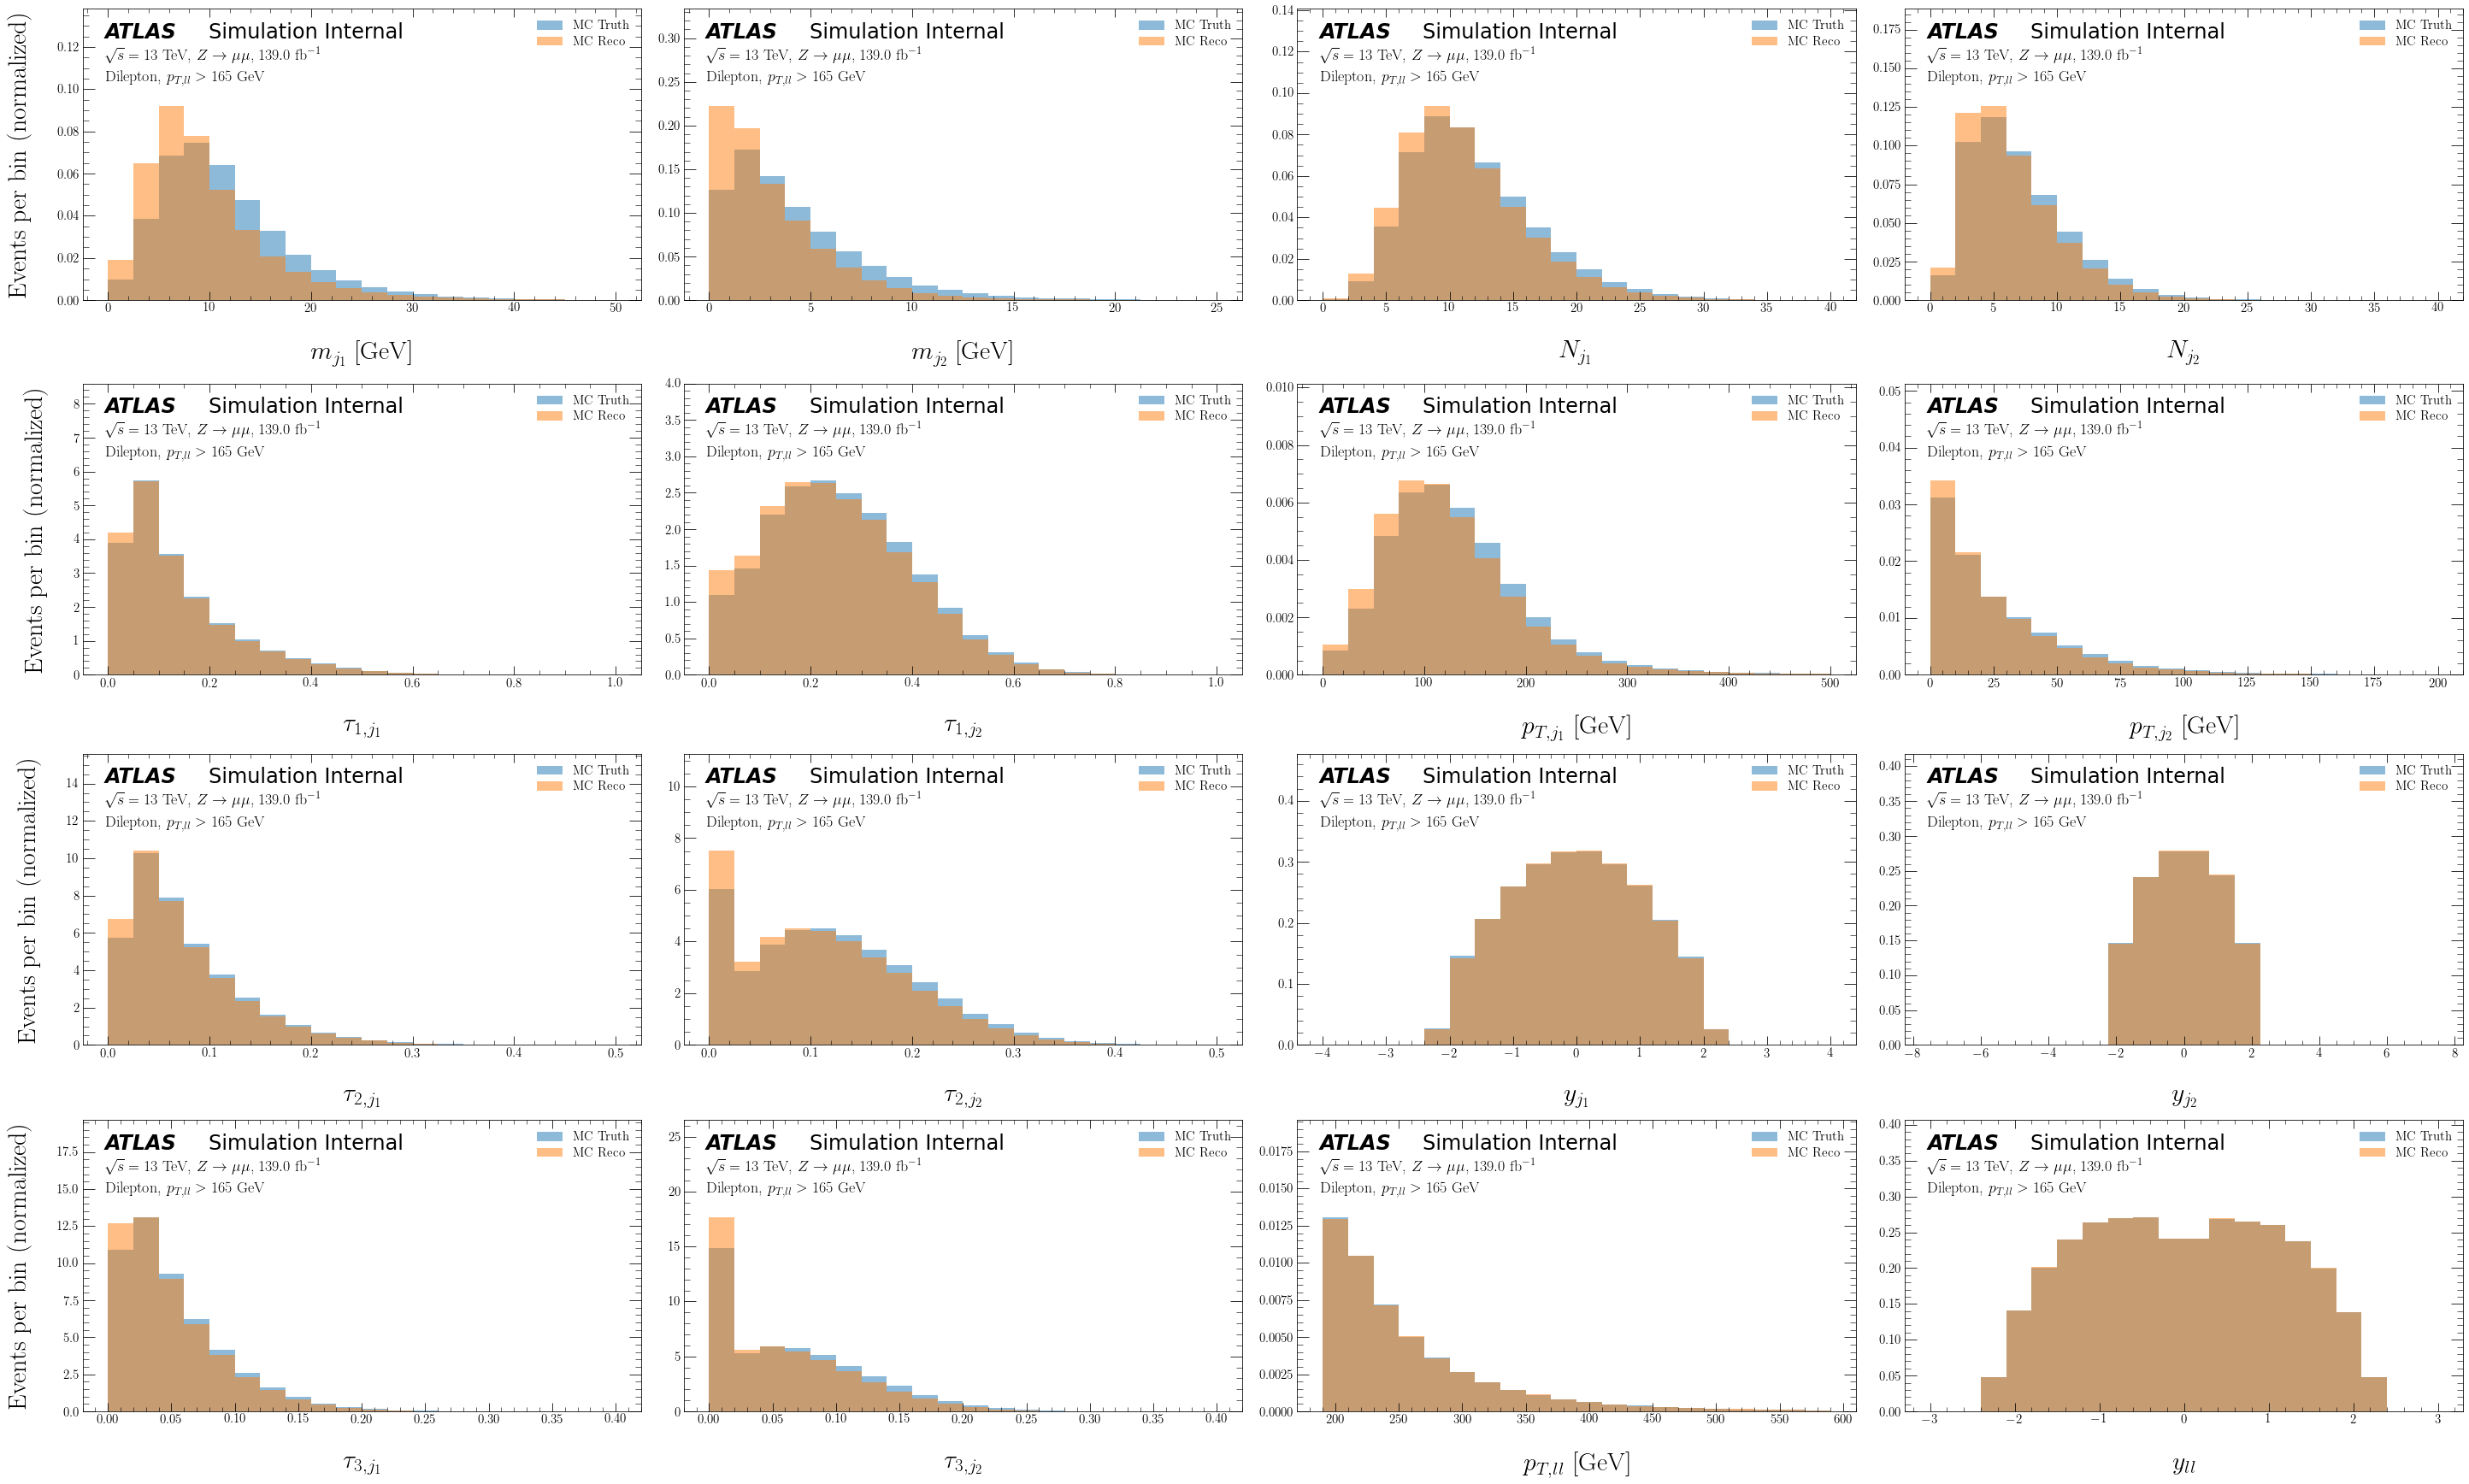

In [29]:
# Preview Observables

fig, ax = plt.subplots(4, 4, figsize=(40, 24), constrained_layout=True)
ax = np.ndarray.flatten(ax)

for i in range(len(obs)):
    bins = obs[i]['bins']
    hT, _, _ = ax[i].hist(Events_sim.events['truth_' +
                                          obs[i]['file_label']][mypass_sim],
                          weights=sim_weights_MC,
                          bins=bins,
                          label="MC Truth", **plot_style_2)
    hR, _, _ = ax[i].hist(Events_sim.events[obs[i]['file_label']][mypass_sim],
                          weights=sim_weights_MC,
                          bins=bins,
                          label="MC Reco", **plot_style_2)
    ax[i].set_xlabel(obs[i]['plot_label'].encode('unicode-escape').decode())
    draw_atlas_text(ax=ax[i])
    if i % 4 == 0:
        ax[i].set_ylabel("Events per bin (normalized)")
    ax[i].legend()
    ax[i].set_ylim([0, 1.5 * max(max(hT), max(hR))])

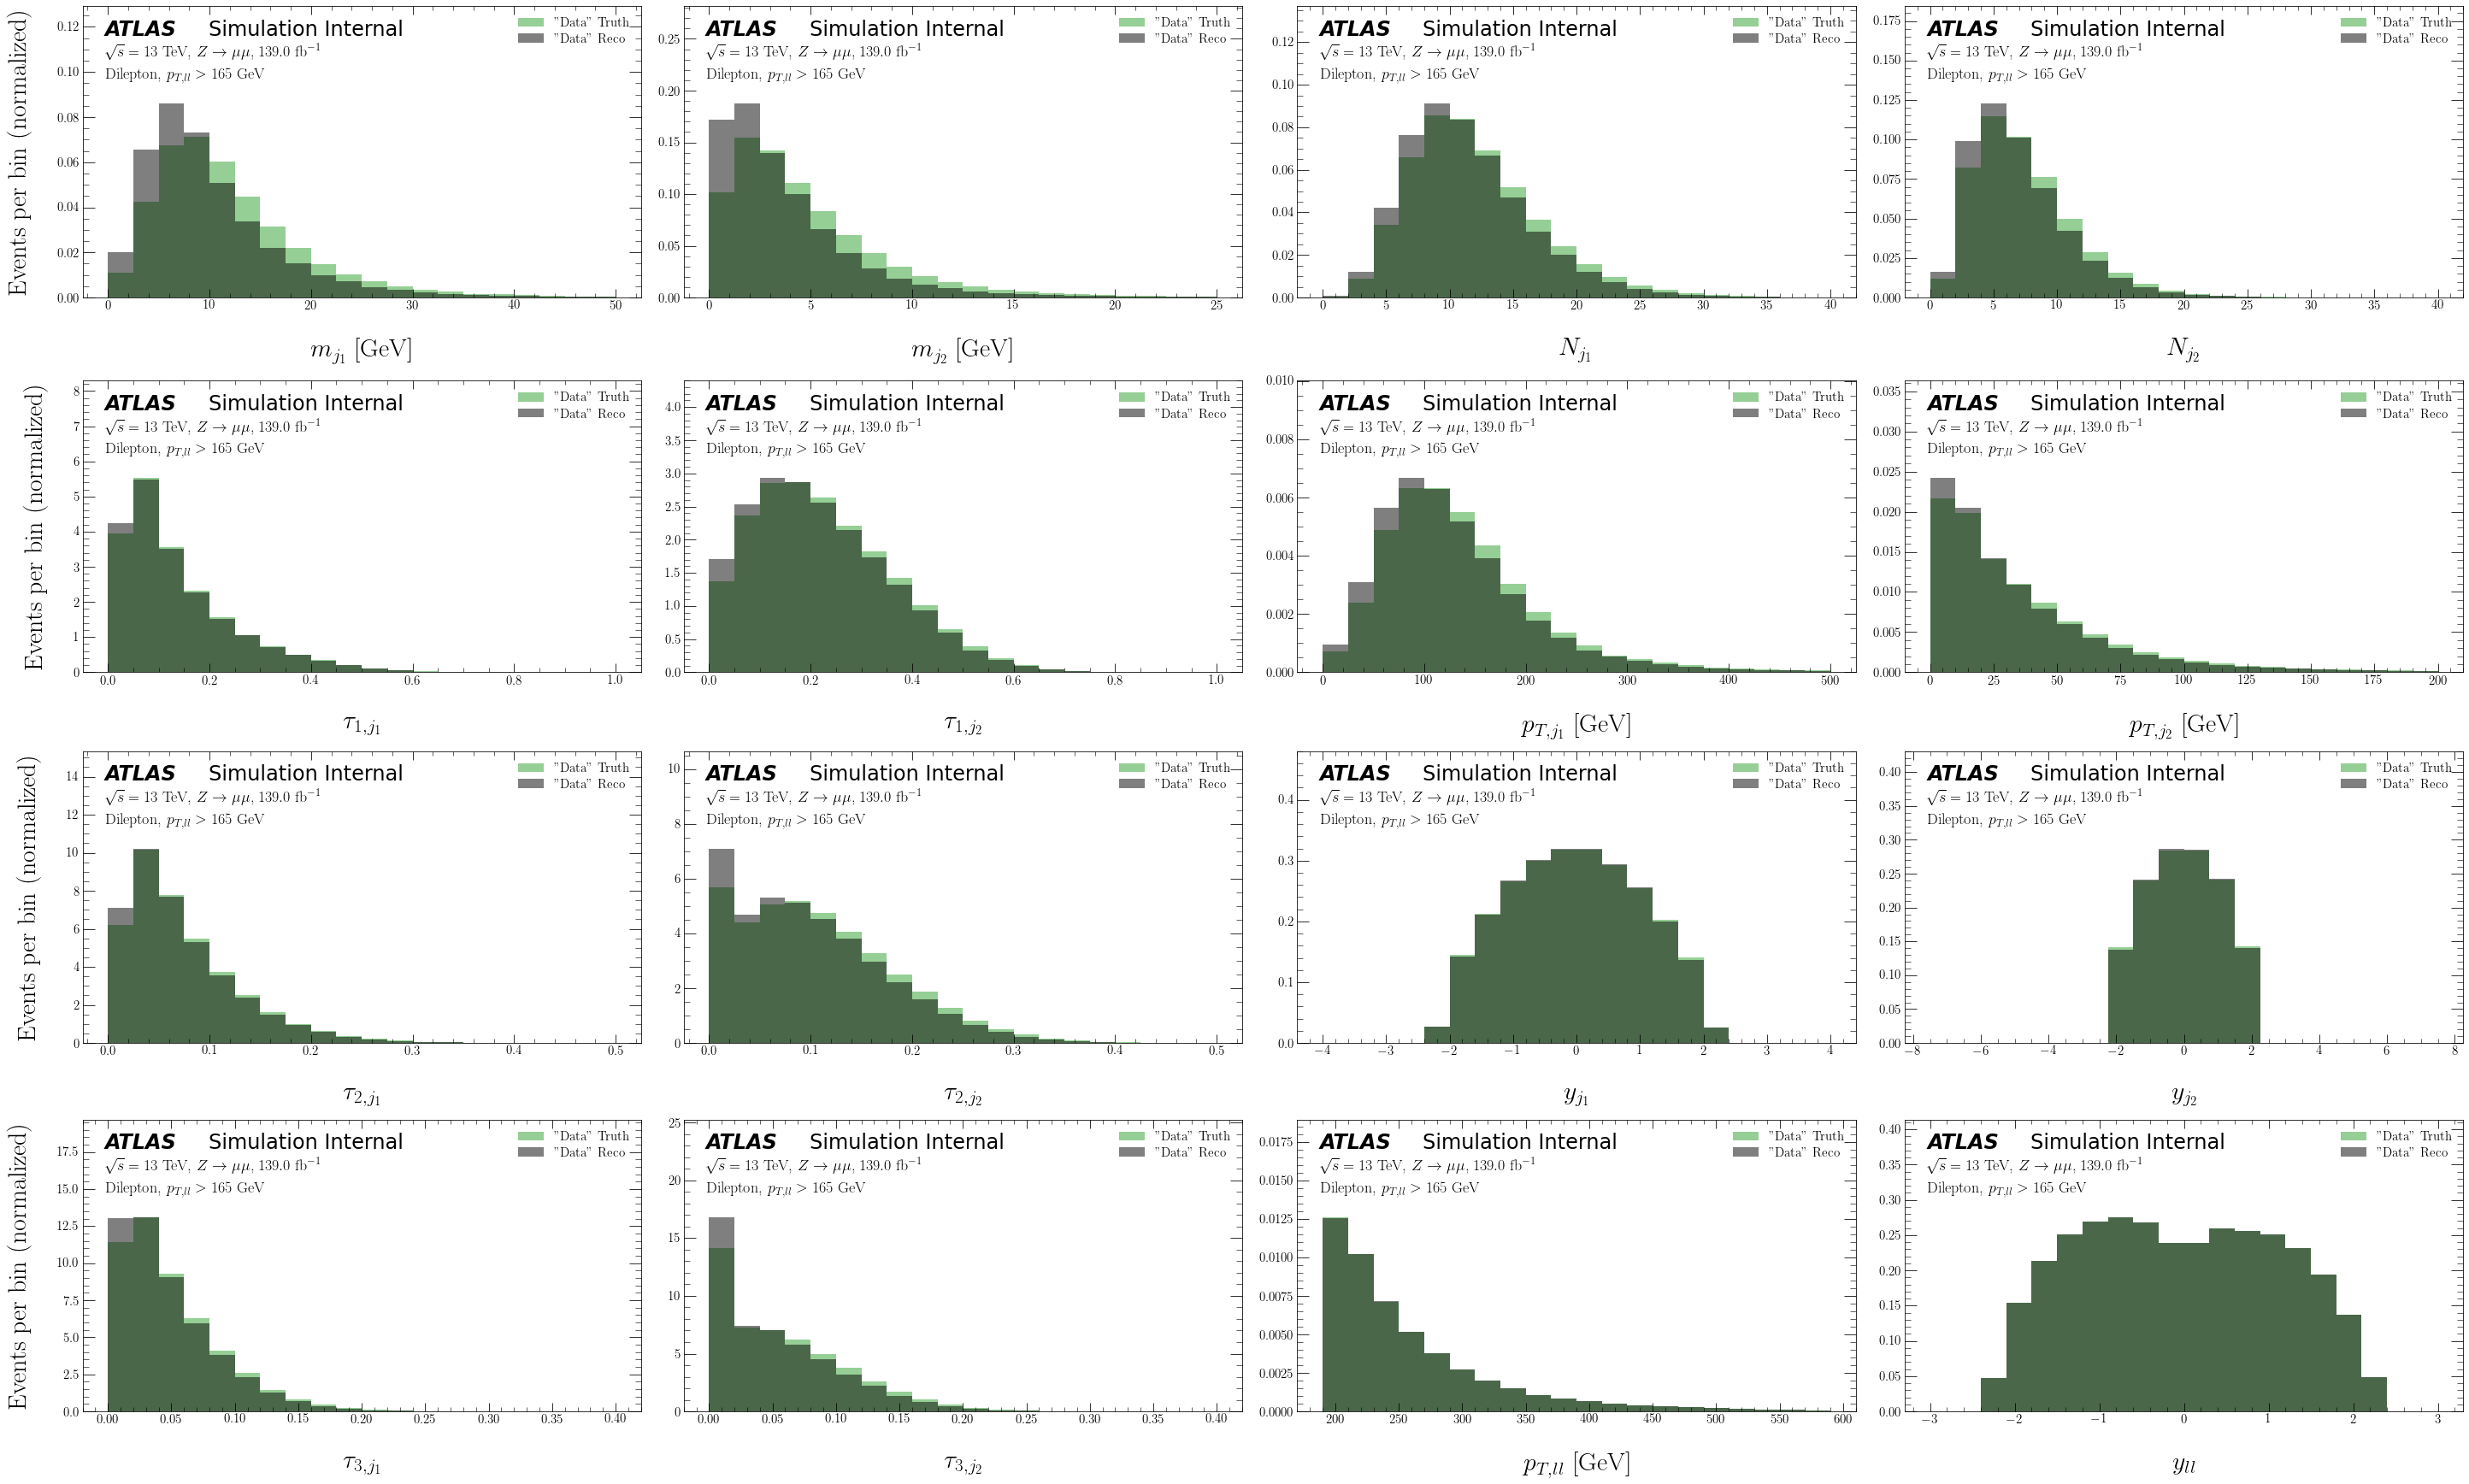

In [30]:
# Preview Observables

fig, ax = plt.subplots(4, 4, figsize=(40, 24), constrained_layout=True)
ax = np.ndarray.flatten(ax)

for i in range(len(obs)):
    bins = obs[i]['bins']
    hT, _, _ = ax[i].hist(Events_data.events['truth_' +
                                          obs[i]['file_label']][mypass_data],
                          weights=data_weights_MC,
                          bins=bins,
                          label='"Data" Truth', color='C2', **plot_style_2)
    hR, _, _ = ax[i].hist(Events_data.events[obs[i]['file_label']][mypass_data],
                          weights=data_weights_MC,
                          bins=bins,
                          label='"Data" Reco', color='k', **plot_style_2)
    ax[i].set_xlabel(obs[i]['plot_label'].encode('unicode-escape').decode())
    draw_atlas_text(ax=ax[i])
    if i % 4 == 0:
        ax[i].set_ylabel("Events per bin (normalized)")
    ax[i].legend()
    ax[i].set_ylim([0, 1.5 * max(max(hT), max(hR))])

### Define UniFold Algorithm

In [31]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        sim_truth: MC Truth observable as Numpy array
                    
        sim_reco: MC Reco observable as Numpy array
                    
        data_reco: Data Reco observable 
                            to be unfolded as Numpy arrays
                            
        sim_weights_MC: (optional) initial MC generator weights for simulation sample
        
        data_weights_MC: (optional) initial MC generator weights for "data" sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            sim_truth,
            sim_reco,
            data_reco,
            sim_weights_MC=None,
            data_weights_MC=None):

    if sim_weights_MC is None:
        sim_weights_MC = np.ones(len(sim_truth))

    if data_weights_MC is None:
        data_weights_MC = np.ones(len(data_reco))

    labels_sim = np.zeros(len(sim_reco))
    labels_data = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_sim, labels_data))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_sim, (labels_sim + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = sim_weights_MC
    weights_push = sim_weights_MC

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, data_weights_MC))
        # iterative weights for MC Reco, initial weights for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights_pull[np.argwhere(
            np.isinf(weights_pull))] = sim_weights_MC[np.argwhere(
                np.isinf(weights_pull))]
        weights[i, :1, :] = weights_pull

        # STEP 2: classify nominal MC Truth to reweighted (by weights_pull) MC Truth
        # weights nominal MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((sim_weights_MC, weights_pull))
        # initial weights for MC Truth, iterative weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = sim_weights_MC * reweight(model, sim_truth)
        weights_push[np.argwhere(
            np.isinf(weights_push))] = sim_weights_MC[np.argwhere(
                np.isinf(weights_push))]
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define MultiFold Algorithm

In [32]:
# Input multiple observables as tuple or list (i.e. sim_truth = (obs_1, obs_2, ...))
"""    Arguments:

        iterations: number of iterations (integer)
        
        sim_truth: tuple or list of MC Truth 
                    observables as Numpy arrays
                    
        sim_reco: tuple or list of MC Reco 
                    observables as Numpy arrays
                    
        data_reco: tuple or list of Data Reco 
                    observables to be unfolded 
                    as Numpy arrays
        
        sim_weights_MC: (optional) initial MC generator weights for simulation sample
        
        data_weights_MC: (optional) initial MC generator weights for "data" sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def multifold(iterations,
              sim_truth,
              sim_reco,
              data_reco,
              sim_weights_MC=None,
              data_weights_MC=None):

    num_observables = len(sim_truth)

    sim_truth = np.stack(sim_truth, axis=1)
    sim_reco = np.stack(sim_reco, axis=1)
    data_reco = np.stack(data_reco, axis=1)

    if sim_weights_MC is None:
        sim_weights_MC = np.ones(len(sim_truth))

    if data_weights_MC is None:
        data_weights_MC = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = sim_weights_MC
    weights_push = sim_weights_MC

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, data_weights_MC))
        # actual weights for MC Reco, ones for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights_pull[np.argwhere(
            np.isinf(weights_pull))] = sim_weights_MC[np.argwhere(
                np.isinf(weights_pull))]
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((sim_weights_MC, weights_pull))
        # ones for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = sim_weights_MC * reweight(model, sim_truth)
        weights_push[np.argwhere(
            np.isinf(weights_push))] = sim_weights_MC[np.argwhere(
                np.isinf(weights_push))]
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define OmniFold Algorithm

In [33]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        sim_truth: MC Truth events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        sim_truth: MC Reco events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        data_reco: Data Reco events 
                            (i.e. list of events with particles as 
                            (pT, eta, phi, charge))
                            to be unfolded as zero-padded Numpy array 
                            
        
        sim_weights_MC: (optional) initial MC generator weights for simulation sample
        
        data_weights_MC: (optional) initial MC generator weights for data sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def omnifold(iterations,
             sim_truth,
             sim_reco,
             data_reco,
             sim_truth_global=None,
             sim_reco_global=None,
             data_reco_global=None,
             sim_weights_MC=None,
             data_weights_MC=None):

    if sim_truth_global is None:
        sim_truth_global = np.ones(len(sim_truth)) * np.nan

    if sim_reco_global is None:
        sim_reco_global = np.ones(len(sim_reco)) * np.nan

    if sim_reco_global is None:
        sim_reco_global = np.ones(len(data_reco)) * np.nan

    if sim_weights_MC is None:
        sim_weights_MC = np.ones(len(sim_truth))

    if data_weights_MC is None:
        data_weights_MC = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    xvals_global_1 = np.concatenate((sim_reco_global, data_reco_global))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    xvals_global_2 = np.concatenate((sim_truth_global, sim_truth_global))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = sim_weights_MC
    weights_push = sim_weights_MC

    # network architecture parameters
    Phi_sizes = (100, 100, 128)
    F_sizes = (100, 100, 100)

    model = PFN(input_dim=3,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                latent_dropout=0.2,
                F_dropouts=0.2,
                output_dim=1,
                output_act='sigmoid',
                summary=False)

    earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

    print("Jumpstarting Model\n")
    count = 0
    while count < 20:
        count += 1

        X_train_1, X_test_1, X_train_global_1, X_test_global_1, Y_train_1, Y_test_1 = train_test_split(
            xvals_1, xvals_global_1, yvals_1)

        if X_train_global_1[0] is not np.nan:
            X_train_1 = [X_train_1, X_train_global_1]
            X_test_1 = [X_test_1, X_test_global_1]

        model.model.compile(loss='binary_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])
        history = model.fit(X_train_1,
                            Y_train_1,
                            epochs=1,
                            batch_size=1000,
                            validation_data=(X_test_1, Y_test_1),
                            verbose=1)
        if (history.history['val_loss'][0] < history.history['loss'][0] -
                0.1) or history.history['val_loss'][0] < 1:
            break
        else:
            K.clear_session()

            model = PFN(input_dim=3,
                        Phi_sizes=Phi_sizes,
                        F_sizes=F_sizes,
                        latent_dropout=0.2,
                        F_dropouts=0.2,
                        output_dim=1,
                        output_act='sigmoid',
                        summary=False)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, data_weights_MC))
        # actual weights for MC Reco, initial MC for Data Reco

        X_train_1, X_test_1, X_train_global_1, X_test_global_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, xvals_global_1, yvals_1, weights_1)

        if X_train_global_1[0] is not np.nan:
            X_train_1 = [X_train_1, X_train_global_1]
            X_test_1 = [X_test_1, X_test_global_1]

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.model.compile(loss=weighted_binary_crossentropy,
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((sim_weights_MC, weights_pull))
        # initial MC for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, X_train_global_2, X_test_global_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, xvals_global_2, yvals_2, weights_2)

        if X_train_global_2[0] is not np.nan:
            X_train_2 = [X_train_2, X_train_global_2]
            X_test_2 = [X_test_2, X_test_global_2]

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.model.compile(loss=weighted_binary_crossentropy,
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = sim_weights_MC * reweight(model, sim_truth)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Plotting

In [34]:
def plot_distributions(sim_truth,
                       sim_reco,
                       data_reco,
                       bins,
                       x_label,
                       data_weights_MC=None,
                       sim_weights_MC=None,
                       data_truth=None,
                       save_label=None):

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(20, 6),
                           constrained_layout=True,
                           sharey=True)

    hT0, _, _ = ax[0].hist(sim_truth,
                           weights=sim_weights_MC,
                           bins=bins,
                           label='MC Truth',
                           **plot_style_2,
                           color='C0')
    hR0, _, _ = ax[0].hist(sim_reco,
                           weights=sim_weights_MC,
                           bins=bins,
                           label='MC Reco',
                           **plot_style_2,
                           color='C1')
    ax[0].set_xlabel(x_label.encode('unicode-escape').decode())
    ax[0].set_ylabel('Events per bin (normalized)')
    legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
    plt.setp(legend.get_title(), multialignment='center')
    draw_atlas_text(ax=ax[0])

    hT1, _, _ = ax[1].hist(data_truth,
                           weights=data_weights_MC,
                           bins=bins,
                           label='"Data" Truth',
                           **plot_style_2,
                           color='C2')
    hR1, _, _ = ax[1].hist(data_reco,
                           weights=data_weights_MC,
                           bins=bins,
                           label='"Data" Reco',
                           **plot_style_2,
                           color='k')
    ax[1].set_xlabel(x_label.encode('unicode-escape').decode())
    ax[1].set_ylim([0, 1.5 * np.max((hT0, hR0, hT1, hR1))])
    legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
    plt.setp(legend.get_title(), multialignment='center')
    draw_atlas_text(ax=ax[1])
    if save_label is not None:
        fig.savefig(save_label + '-Distributions.pdf', bbox_inches='tight', backend='pgf')
    fig.show()

In [35]:
def plot_results(sim_truth,
                 sim_reco,
                 data_reco,
                 weights,
                 bins,
                 x_label,
                 data_weights_MC=None,
                 sim_weights_MC=None,
                 data_truth=None,
                 save_label=None):

    if sim_weights_MC is None:
        sim_weights_MC = np.ones(len(sim_reco))
    if data_weights_MC is None:
        data_weights_MC = np.ones(len(data_reco))

    for i in range(len(weights)):
        print("ITERATION {}:".format(i + 1))

        fig, ax = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)

        if i == 0:
            weights_init = sim_weights_MC
            label0 = ''
            label1 = ', iter-{}'.format(i + 1)
        else:
            weights_init = weights[i - 1, 1, :]
            label0 = ', iter-{}'.format(i)
            label1 = ', iter-{}'.format(i + 1)

        hR0, _, _ = ax[0].hist(sim_reco,
                               weights=weights_init,
                               bins=bins,
                               label='MC Reco' + label0 + '\n' +
                               r'(wgt.$=\nu_{{{}}}$)'.format(i),
                               **plot_style_2,
                               color='C1')

        hR1, _, _ = ax[0].hist(sim_reco,
                               weights=weights[i, 0, :],
                               bins=bins,
                               label='MC Reco' + label1 + '\n' +
                               r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                               **plot_style_1)
        hR2, _, _ = ax[0].hist(data_reco,
                               weights=data_weights_MC,
                               bins=bins,
                               label='"Data" Reco (Target)',
                               **plot_style_2,
                               color='k')
        ax[0].set_xlabel(x_label.encode('unicode-escape').decode())
        ax[0].set_ylabel("Events per bin (normalized)")
        ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])
        draw_atlas_text(ax=ax[0])
        ax[0].legend()
        hT0, _, _ = ax[1].hist(sim_truth,
                               weights=sim_weights_MC,
                               bins=bins,
                               label=r'MC Truth',
                               **plot_style_2)

        hT1, _, _ = ax[1].hist(sim_truth,
                               weights=weights[i, 1, :],
                               bins=bins,
                               label='OmniFolded "Data"' + label1 + '\n' +
                               r'(wgt.$=\nu_{}$)'.format(i + 1),
                               **plot_style_1)
        if data_truth is not None:
            hT2, _, _ = ax[1].hist(data_truth,
                                   weights=data_weights_MC,
                                   bins=bins,
                                   label='"Data" Truth (Target)',
                                   **plot_style_2,
                                   color='C2')
        ax[1].legend()
        ax[1].set_xlabel(x_label.encode('unicode-escape').decode())
        ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])
        draw_atlas_text(ax=ax[1])
        fig.show()
        if save_label is not None:
            fig.savefig(save_label + '-Iteration{:02}.pdf'.format(i + 1),
                        bbox_inches='tight',
                        backend='pgf')
        plt.show()

# OmniFold

## Setup Datasets

### Load and process tracks

In [36]:
truth_pT_tracks_sim = Events_sim.events['truth_pT_tracks'][mypass_sim]
pT_tracks_sim = Events_sim.events['pT_tracks'][mypass_sim]

truth_eta_tracks_sim = Events_sim.events['truth_eta_tracks'][mypass_sim]
eta_tracks_sim = Events_sim.events['eta_tracks'][mypass_sim]

truth_phi_tracks_sim = Events_sim.events['truth_phi_tracks'][mypass_sim]
phi_tracks_sim = Events_sim.events['phi_tracks'][mypass_sim]

                                                             
# truth_pT_tracks_data = Events_data.events['truth_pT_tracks'][mypass_data]
pT_tracks_data = Events_data.events['pT_tracks'][mypass_data]

# truth_eta_tracks_data = Events_data.events['truth_eta_tracks'][mypass_data]
eta_tracks_data = Events_data.events['eta_tracks'][mypass_data]

# truth_phi_tracks_data = Events_data.events['truth_phi_tracks'][mypass_data]
phi_tracks_data = Events_data.events['phi_tracks'][mypass_data]

In [37]:
truth_pT_trackj2_sim = Events_sim.events['truth_pT_trackj2'][mypass_sim]
pT_trackj2_sim = Events_sim.events['pT_trackj2'][mypass_sim]

truth_y_trackj2_sim = Events_sim.events['truth_y_trackj2'][mypass_sim]
y_trackj2_sim = Events_sim.events['y_trackj2'][mypass_sim]

truth_phi_trackj2_sim = Events_sim.events['truth_phi_trackj2'][mypass_sim]
phi_trackj2_sim = Events_sim.events['phi_trackj2'][mypass_sim]

truth_pT_trackj2_data = Events_data.events['truth_pT_trackj2'][mypass_data]
pT_trackj2_data = Events_data.events['pT_trackj2'][mypass_data]

truth_y_trackj2_data = Events_data.events['truth_y_trackj2'][mypass_data]
y_trackj2_data = Events_data.events['y_trackj2'][mypass_data]

truth_phi_trackj2_data = Events_data.events['truth_phi_trackj2'][mypass_data]
phi_trackj2_data = Events_data.events['phi_trackj2'][mypass_data]

In [38]:
def get_jets(pT, eta, phi, jet_phi, jet_eta, dRmin=0.4):
    jets = []

    for i in range(len(pT)):
        jet = []
        for j in range(len(pT[i])):
            dR = ((jet_eta[i] - eta[i, j])**2 +
                  (np.arccos(np.cos(jet_phi[i] - phi[i, j])))**2)**0.5
            if dR < dRmin:
                jet.append([pT[i, j], eta[i, j], phi[i, j]])
        if jet==[]:
            jet =[[0, 0, 0]]
        jets.append(jet)      
        
    return jets

In [39]:
truth_jet_sim = get_jets(truth_pT_tracks_sim, truth_eta_tracks_sim,
                         truth_phi_tracks_sim, truth_phi_trackj2_sim, truth_y_trackj2_sim)
jet_sim = get_jets(pT_tracks_sim, eta_tracks_sim,
                         phi_tracks_sim, phi_trackj2_sim, y_trackj2_sim)

jet_data = get_jets(pT_tracks_data, eta_tracks_data,
                         phi_tracks_data, phi_trackj2_data, y_trackj2_data)

In [40]:
def get_max_dim(array):
    max_dim = max([len(array[i]) for i in range(len(array))])

    return max_dim

In [41]:
# normalize or standardize pT and center (y, phi)
def normalize_event(x, normalize=True):
    if normalize:
        if x[0, 0] != 0:
            yphi_avg = np.average(x[:, 1:3], weights=x[:, 0], axis=0)
            x[:, 1:2] = np.arccos(np.cos(x[:, 1:2] - yphi_avg[0]))
            x[:, 2:3] -= yphi_avg[1]
            x[:, 0] /= x[:, 0].sum()
    else:  # standardize
        x[:, 0] /= 100.
    return x

In [42]:
def preprocess_jets(jets, max_num_particles=None):
    num_events = len(jets)
    if max_num_particles == None:
        max_num_particles = get_max_dim(pT)

    result = np.empty(shape=(num_events, max_num_particles, 3))

    for i in range(num_events):
        pad_length = max_num_particles - len(jets[i])
        pad = np.zeros(shape=(pad_length, 3))

        event = np.array(jets[i])
        event = normalize_event(event)

        result[i] = np.concatenate((event, pad))

    return result

In [43]:
max_num_particles_truth = get_max_dim(truth_jet_sim)
max_num_particles_reco = max(get_max_dim(jet_sim), get_max_dim(jet_data))

In [44]:
sim_truth = preprocess_jets(truth_jet_sim, max_num_particles_truth)
sim_reco = preprocess_jets(jet_sim,
                           max_num_particles_reco)

# data_truth = preprocess_jets(truth_pT_tracks_data, truth_eta_tracks_data,
#                              truth_phi_tracks_data, max_num_particles_truth)
data_reco = preprocess_jets(jet_data,
                            max_num_particles_reco)

### Load observables

In [45]:
obs_index = [1, 3, 5, 7, 9, 11, 13]

In [46]:
sim_truth_obs = [None] * len(obs_index)
sim_reco_obs = [None] * len(obs_index)
data_truth_obs = [None] * len(obs_index)
data_reco_obs = [None] * len(obs_index)

In [47]:
for i in range(len(obs_index)):
    file_label = obs[obs_index[i]]['file_label']

    sim_truth_obs[i] = Events_sim.events['truth_' + file_label][mypass_sim]
    sim_reco_obs[i] = Events_sim.events[file_label][mypass_sim]
    data_truth_obs[i] = Events_data.events['truth_' + file_label][mypass_data]
    data_reco_obs[i] = Events_data.events[file_label][mypass_data]

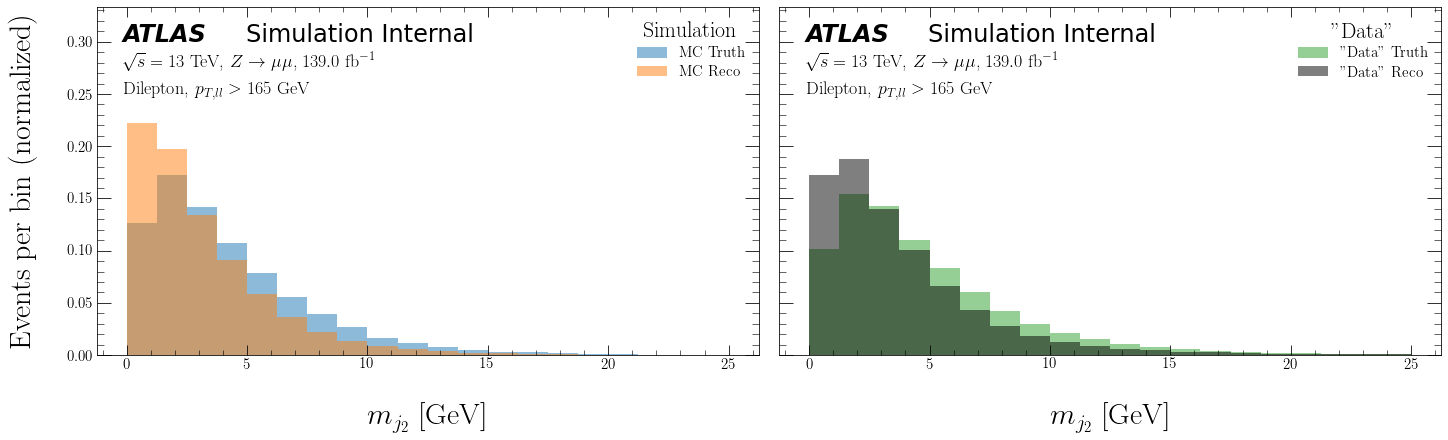

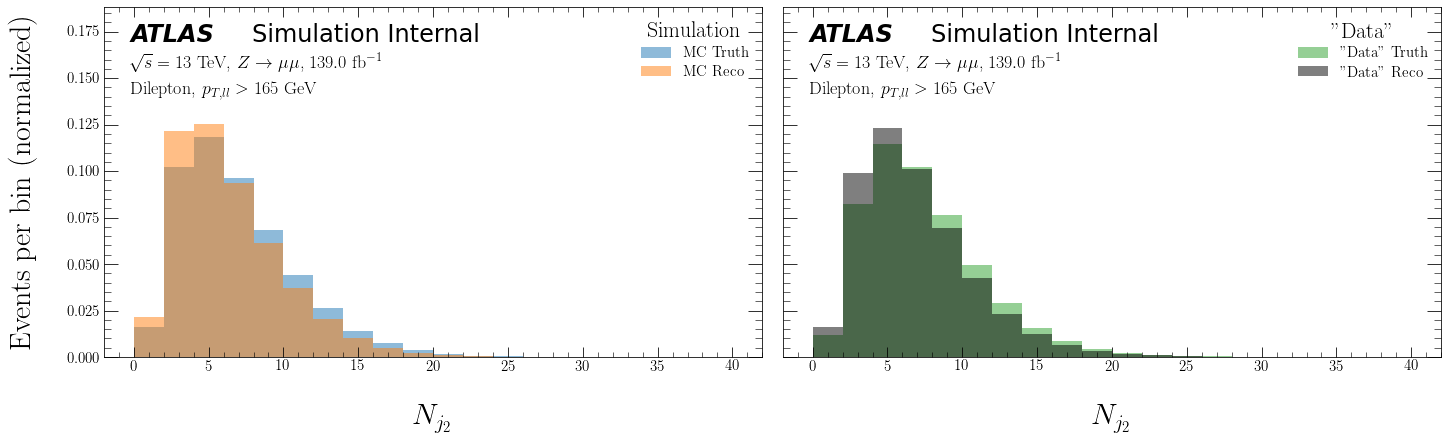

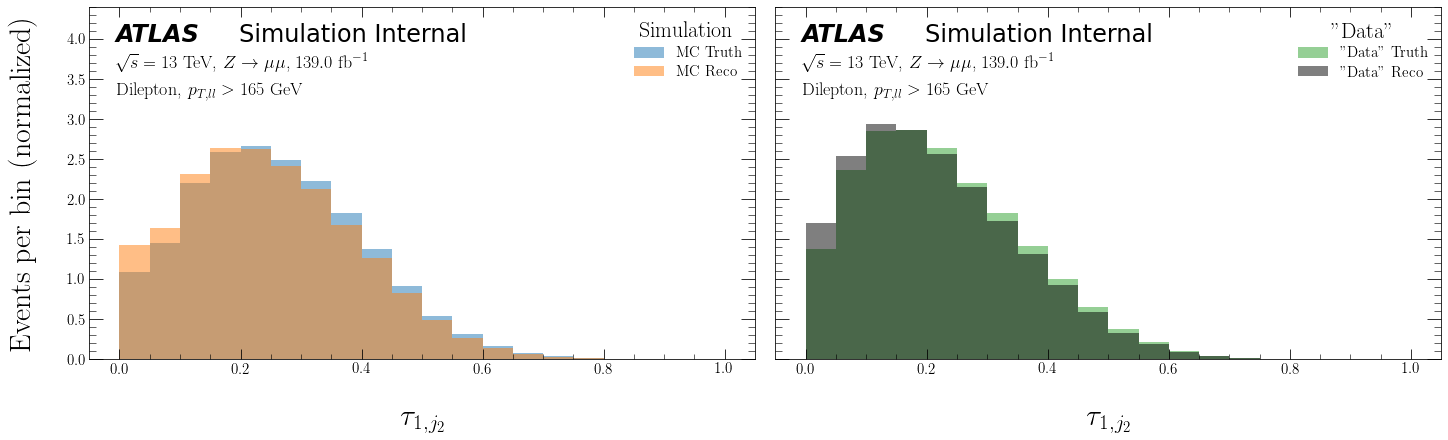

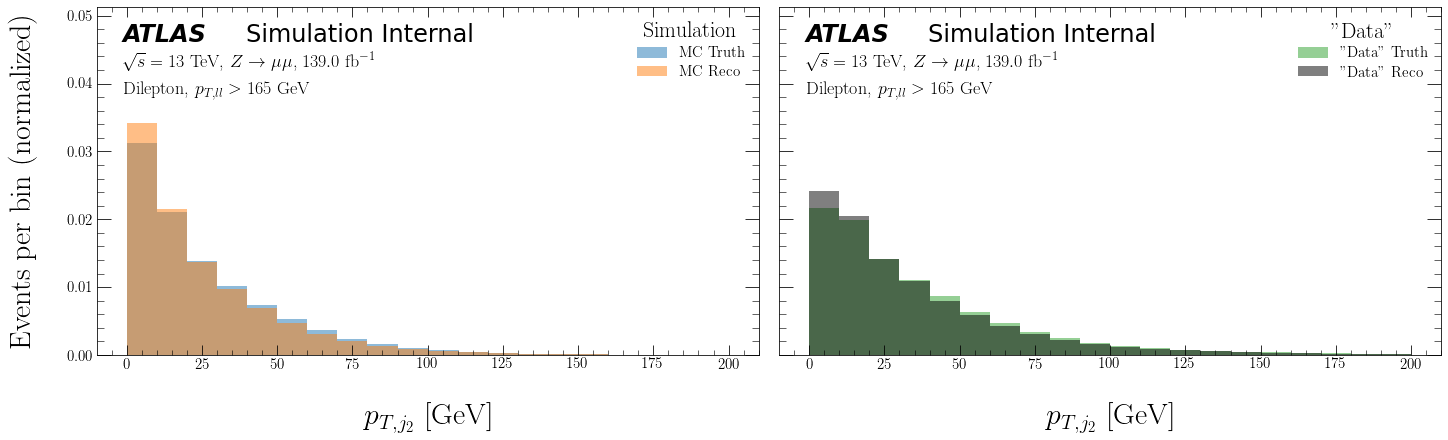

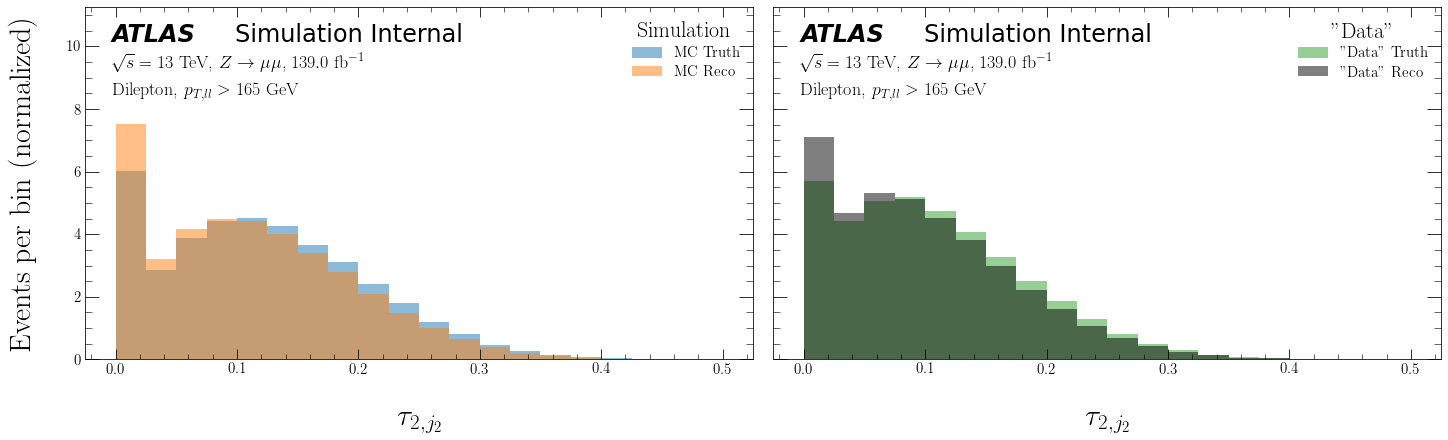

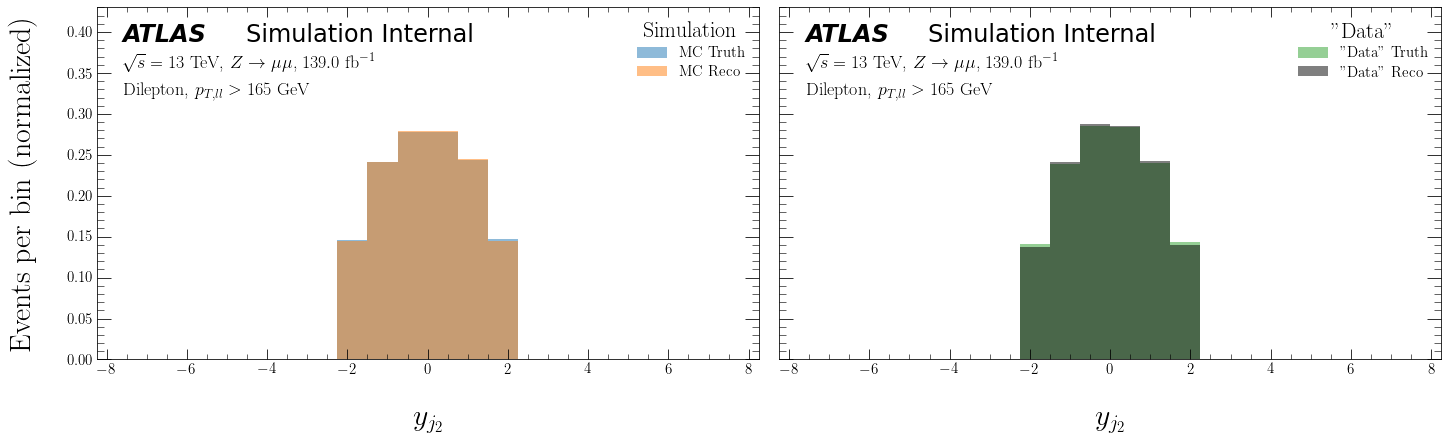

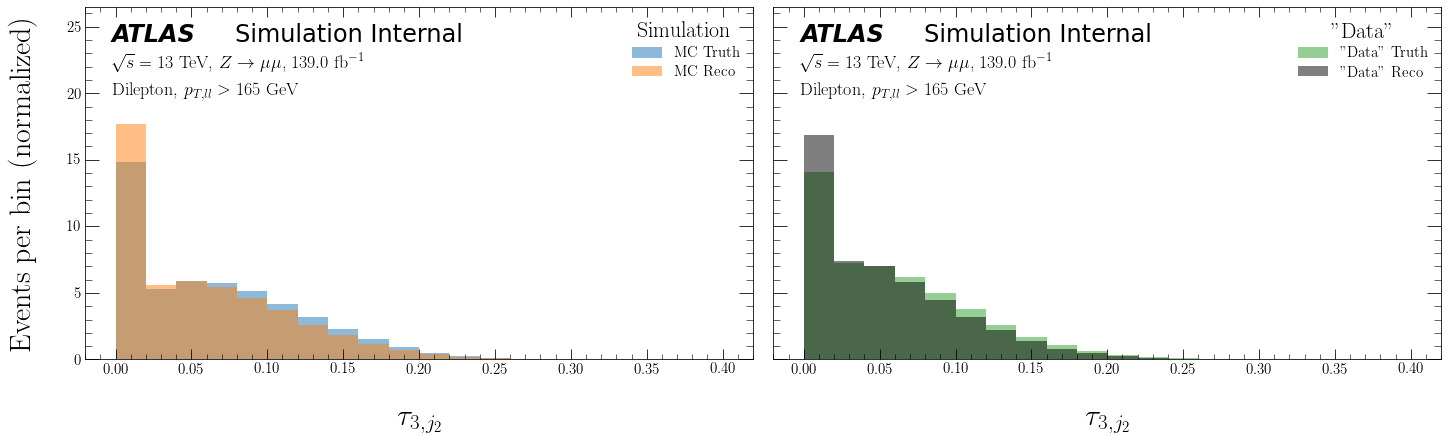

In [48]:
for i in range(len(obs_index)):
    bins = obs[obs_index[i]]['bins']
    x_label = obs[obs_index[i]]['plot_label']
    file_label = obs[obs_index[i]]['file_label']
    save_label = plot_dir + '/OmniFold/' + file_label + '/' + save_label0 + '-OmniFold-' + file_label
    plot_distributions(sim_truth=sim_truth_obs[i],
                       sim_reco=sim_reco_obs[i],
                       sim_weights_MC=sim_weights_MC,
                       data_truth=data_truth_obs[i],
                       data_reco=data_reco_obs[i],
                       data_weights_MC=data_weights_MC,
                       bins=bins,
                       x_label=x_label)#,
#                        save_label=save_label)

## Unfold

In [49]:
# z-score standardization of data
# sim_truth_obs_z = [None] * len(obs)
# sim_reco_obs_z = [None] * len(obs)
# data_reco_obs_z = [None] * len(obs)

# for i in range(len(obs)):
#     sim_truth_obs_z[i], sim_reco_obs_z[i], data_reco_obs_z[i] = standardize(
#         sim_truth_obs[i], sim_reco_obs[i], data_reco_obs[i])

In [50]:
sim_truth_global = np.array([truth_pT_trackj2_sim/100., truth_phi_trackj2_sim, truth_y_trackj2_sim])
sim_truth_global = np.transpose(sim_truth_global)

sim_reco_global = np.array([pT_trackj2_sim/100., phi_trackj2_sim, y_trackj2_sim])
sim_reco_global = np.transpose(sim_reco_global)

data_reco_global = np.array([pT_trackj2_data/100., phi_trackj2_data, y_trackj2_data])
data_reco_global = np.transpose(data_reco_global)

In [51]:
weights, _ = omnifold(iterations=10,
                      sim_truth=sim_truth,
                      sim_truth_global=sim_truth_global,
                      sim_reco=sim_reco,
                      sim_reco_global=sim_reco_global,
                      sim_weights_MC=sim_weights_MC,
                      data_reco=data_reco,
                      data_reco_global=data_reco_global,
                      data_weights_MC=data_weights_MC)

Jumpstarting Model

1759/1759 [==============================] - 11s 6ms/step - loss: 0.3457 - accuracy: 0.8875 - val_loss: 0.3345 - val_accuracy: 0.8895

ITERATION: 1

STEP 1

Epoch 1/200
1759/1759 [==============================] - 50s 28ms/step - loss: 0.3478 - accuracy: 0.4443 - val_loss: 0.3461 - val_accuracy: 0.4443
Epoch 2/200
1759/1759 [==============================] - 50s 28ms/step - loss: 0.3470 - accuracy: 0.4443 - val_loss: 0.3458 - val_accuracy: 0.4443
Epoch 3/200
1759/1759 [==============================] - 49s 28ms/step - loss: 0.3464 - accuracy: 0.4443 - val_loss: 0.3458 - val_accuracy: 0.4443
Epoch 4/200
1759/1759 [==============================] - 50s 29ms/step - loss: 0.3460 - accuracy: 0.4443 - val_loss: 0.3467 - val_accuracy: 0.4443
Epoch 5/200
1759/1759 [==============================] - 50s 28ms/step - loss: 0.3461 - accuracy: 0.4443 - val_loss: 0.3456 - val_accuracy: 0.4443
Epoch 6/200
1759/1759 [==============================] - 52s 30ms/step - loss: 0.3458 - 

1759/1759 [==============================] - 50s 28ms/step - loss: 2.1852 - accuracy: 0.2910 - val_loss: 2.1601 - val_accuracy: 0.2657
Epoch 30/200
1759/1759 [==============================] - 50s 29ms/step - loss: 2.1846 - accuracy: 0.2981 - val_loss: 2.1602 - val_accuracy: 0.2752

STEP 2

Epoch 1/200
392/392 [==============================] - 2s 5ms/step - loss: 1.6822 - accuracy: 0.2501 - val_loss: 1.5635 - val_accuracy: 0.2496
Epoch 2/200
392/392 [==============================] - 2s 4ms/step - loss: 1.5634 - accuracy: 0.2501 - val_loss: 1.5521 - val_accuracy: 0.2496
Epoch 3/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5553 - accuracy: 0.2501 - val_loss: 1.5447 - val_accuracy: 0.2496
Epoch 4/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5528 - accuracy: 0.2501 - val_loss: 1.5409 - val_accuracy: 0.2496
Epoch 5/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5497 - accuracy: 0.2501 - val_loss: 1.5419 - val_accuracy: 

1759/1759 [==============================] - 51s 29ms/step - loss: 2.1190 - accuracy: 0.3343 - val_loss: 2.1455 - val_accuracy: 0.4052
Epoch 10/200
1759/1759 [==============================] - 51s 29ms/step - loss: 2.1188 - accuracy: 0.3375 - val_loss: 2.1468 - val_accuracy: 0.4256
Epoch 11/200
1759/1759 [==============================] - 50s 28ms/step - loss: 2.1182 - accuracy: 0.3347 - val_loss: 2.1447 - val_accuracy: 0.3798
Epoch 12/200
1759/1759 [==============================] - 51s 29ms/step - loss: 2.1180 - accuracy: 0.3306 - val_loss: 2.1445 - val_accuracy: 0.3530
Epoch 13/200
1759/1759 [==============================] - 51s 29ms/step - loss: 2.1183 - accuracy: 0.3348 - val_loss: 2.1455 - val_accuracy: 0.3707
Epoch 14/200
1759/1759 [==============================] - 51s 29ms/step - loss: 2.1178 - accuracy: 0.3316 - val_loss: 2.1460 - val_accuracy: 0.4186
Epoch 15/200
1759/1759 [==============================] - 50s 28ms/step - loss: 2.1178 - accuracy: 0.3335 - val_loss: 2.1451 

Epoch 11/200
1759/1759 [==============================] - 51s 29ms/step - loss: 2.1675 - accuracy: 0.3133 - val_loss: 2.1579 - val_accuracy: 0.2504
Epoch 12/200
1759/1759 [==============================] - 50s 29ms/step - loss: 2.1676 - accuracy: 0.3144 - val_loss: 2.1581 - val_accuracy: 0.2975
Epoch 13/200
1759/1759 [==============================] - 50s 28ms/step - loss: 2.1671 - accuracy: 0.3191 - val_loss: 2.1592 - val_accuracy: 0.4078
Epoch 14/200
1759/1759 [==============================] - 50s 28ms/step - loss: 2.1667 - accuracy: 0.3166 - val_loss: 2.1593 - val_accuracy: 0.3583
Epoch 15/200
1759/1759 [==============================] - 50s 29ms/step - loss: 2.1671 - accuracy: 0.3184 - val_loss: 2.1583 - val_accuracy: 0.3583
Epoch 16/200
1759/1759 [==============================] - 50s 28ms/step - loss: 2.1661 - accuracy: 0.3214 - val_loss: 2.1577 - val_accuracy: 0.2410
Epoch 17/200
1759/1759 [==============================] - 50s 29ms/step - loss: 2.1662 - accuracy: 0.3200 - val_

Epoch 4/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5637 - accuracy: 0.2498 - val_loss: 1.5545 - val_accuracy: 0.2505
Epoch 5/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5609 - accuracy: 0.2498 - val_loss: 1.5503 - val_accuracy: 0.2505
Epoch 6/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5593 - accuracy: 0.2498 - val_loss: 1.5488 - val_accuracy: 0.2505
Epoch 7/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5583 - accuracy: 0.2498 - val_loss: 1.5481 - val_accuracy: 0.2505
Epoch 8/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5573 - accuracy: 0.2498 - val_loss: 1.5475 - val_accuracy: 0.2505
Epoch 9/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5565 - accuracy: 0.2498 - val_loss: 1.5493 - val_accuracy: 0.2505
Epoch 10/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5562 - accuracy: 0.2498 - val_loss: 1.5472 - val_accuracy: 0.250

392/392 [==============================] - 2s 5ms/step - loss: 1.5540 - accuracy: 0.2504 - val_loss: 1.5472 - val_accuracy: 0.2489
Epoch 8/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5533 - accuracy: 0.2504 - val_loss: 1.5480 - val_accuracy: 0.2489
Epoch 9/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5522 - accuracy: 0.2504 - val_loss: 1.5465 - val_accuracy: 0.2489
Epoch 10/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5515 - accuracy: 0.2504 - val_loss: 1.5469 - val_accuracy: 0.2489
Epoch 11/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5506 - accuracy: 0.2504 - val_loss: 1.5466 - val_accuracy: 0.2489
Epoch 12/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5501 - accuracy: 0.2504 - val_loss: 1.5475 - val_accuracy: 0.2489
Epoch 13/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5503 - accuracy: 0.2504 - val_loss: 1.5474 - val_accuracy: 0.2489
Epoch 1

392/392 [==============================] - 2s 5ms/step - loss: 1.5656 - accuracy: 0.2498 - val_loss: 1.5538 - val_accuracy: 0.2507
Epoch 4/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5639 - accuracy: 0.2498 - val_loss: 1.5529 - val_accuracy: 0.2507
Epoch 5/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5632 - accuracy: 0.2498 - val_loss: 1.5532 - val_accuracy: 0.2507
Epoch 6/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5621 - accuracy: 0.2498 - val_loss: 1.5530 - val_accuracy: 0.2507
Epoch 7/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5621 - accuracy: 0.2498 - val_loss: 1.5533 - val_accuracy: 0.2507
Epoch 8/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5609 - accuracy: 0.2498 - val_loss: 1.5540 - val_accuracy: 0.2507
Epoch 9/200
392/392 [==============================] - 2s 5ms/step - loss: 1.5607 - accuracy: 0.2498 - val_loss: 1.5538 - val_accuracy: 0.2507

ITERATION:

### Results

m_trackj2 Results

ITERATION 1:


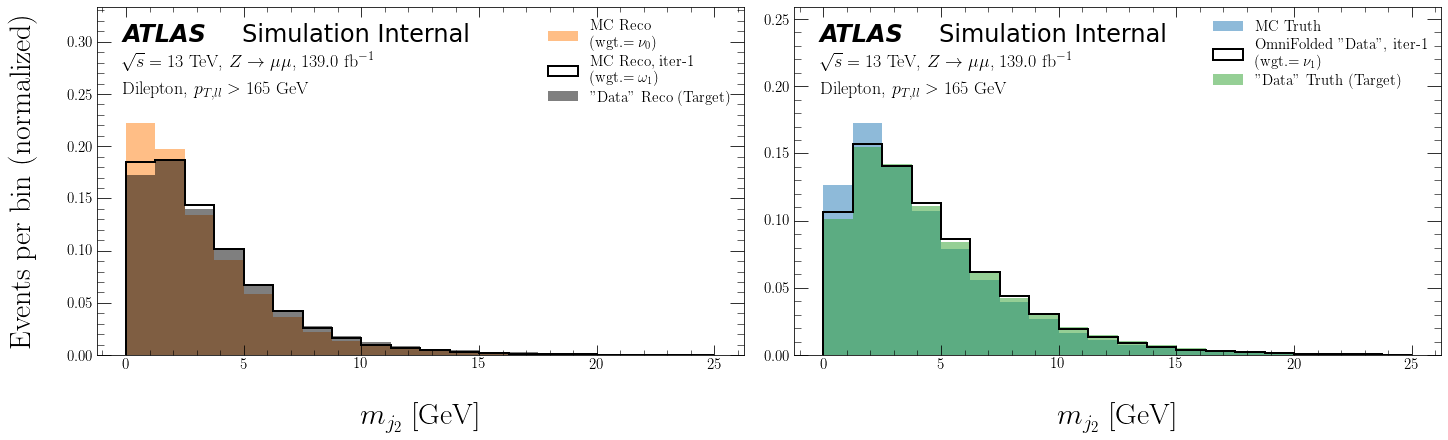

ITERATION 2:


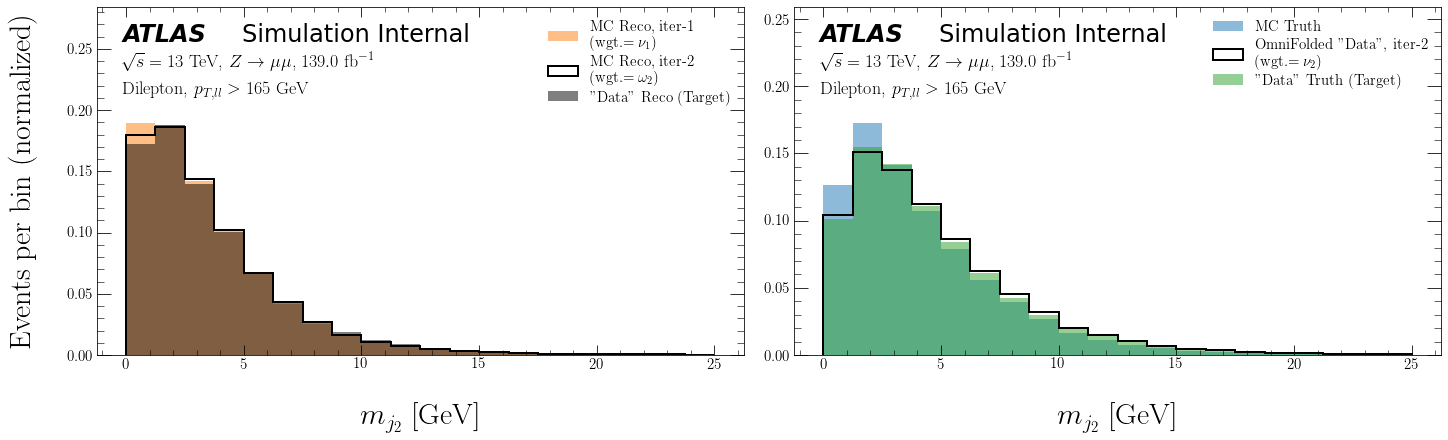

ITERATION 3:


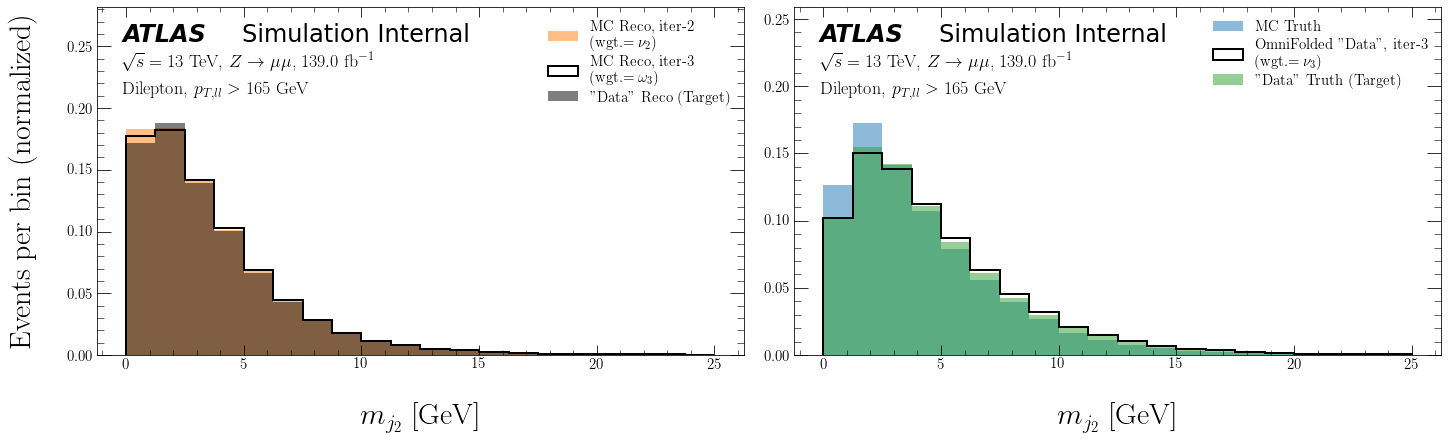

ITERATION 4:


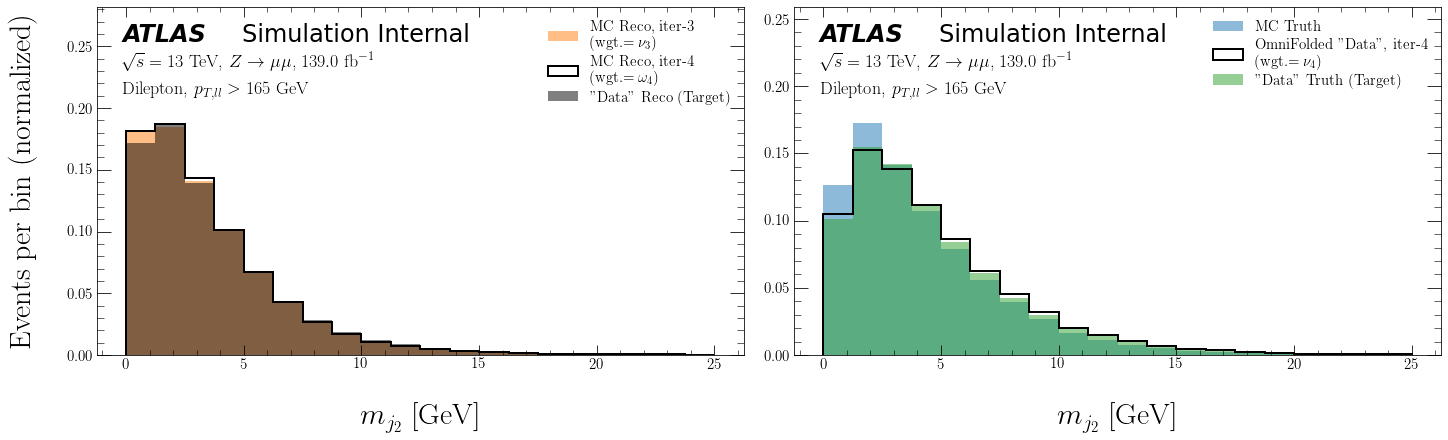

ITERATION 5:


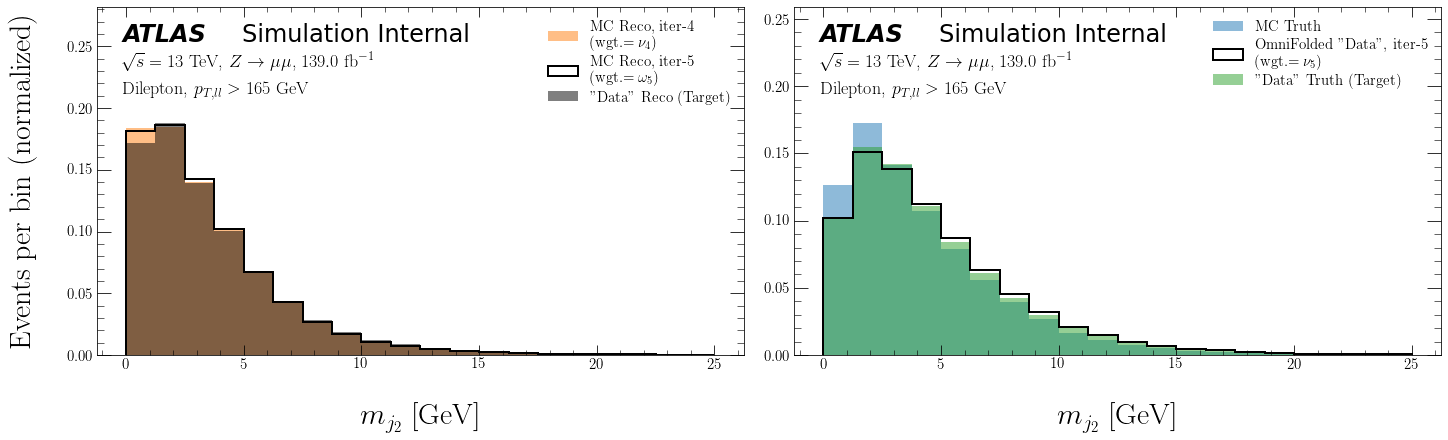

ITERATION 6:


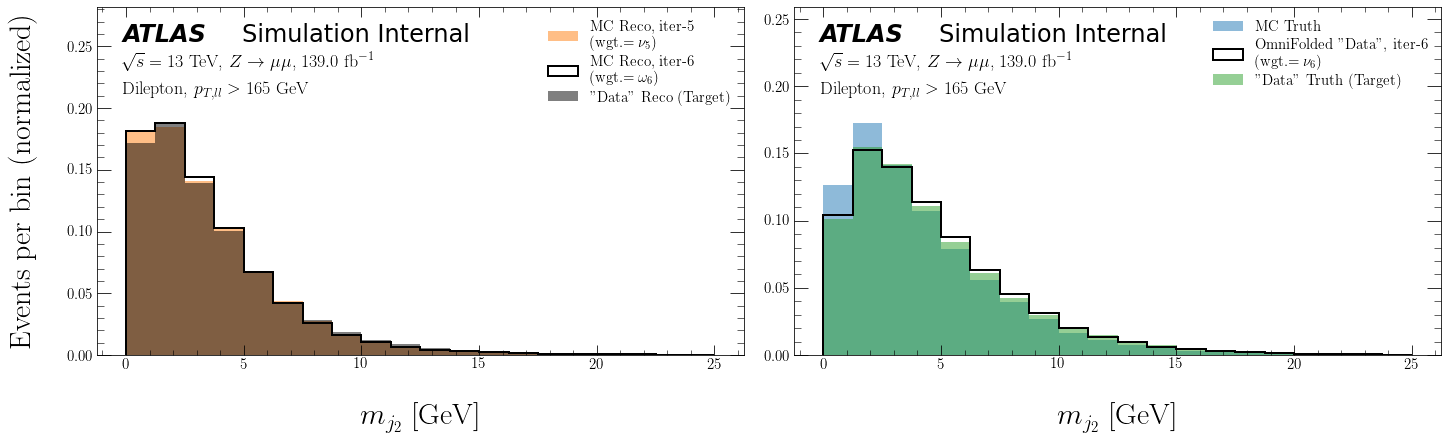

ITERATION 7:


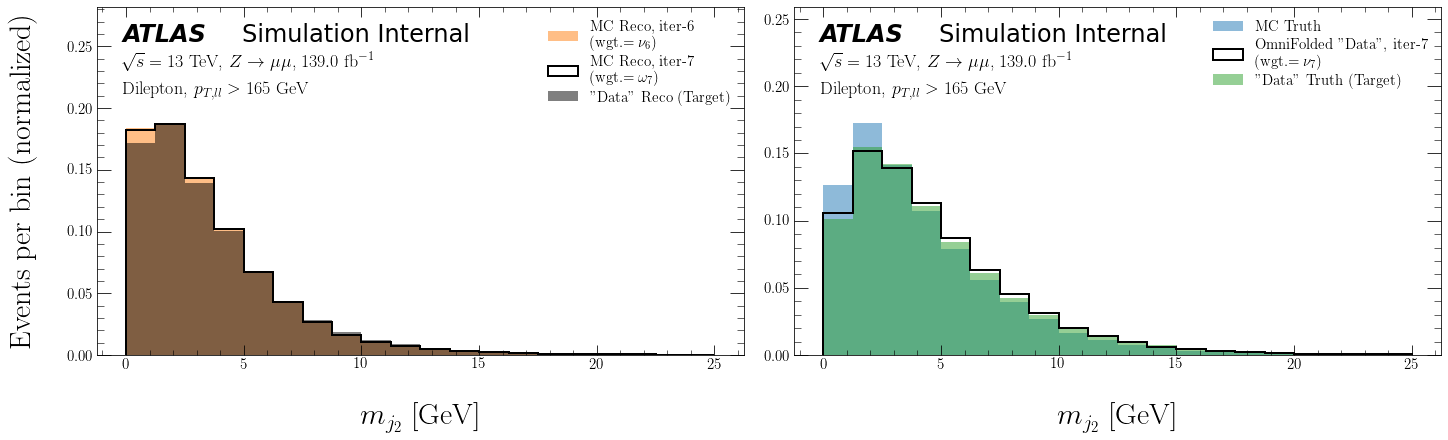

ITERATION 8:


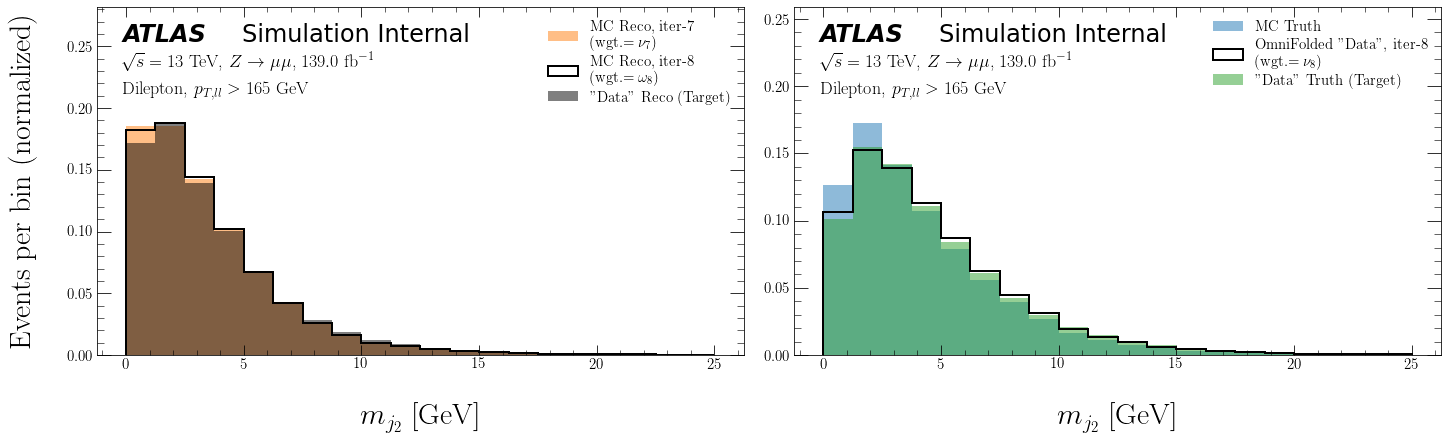

ITERATION 9:


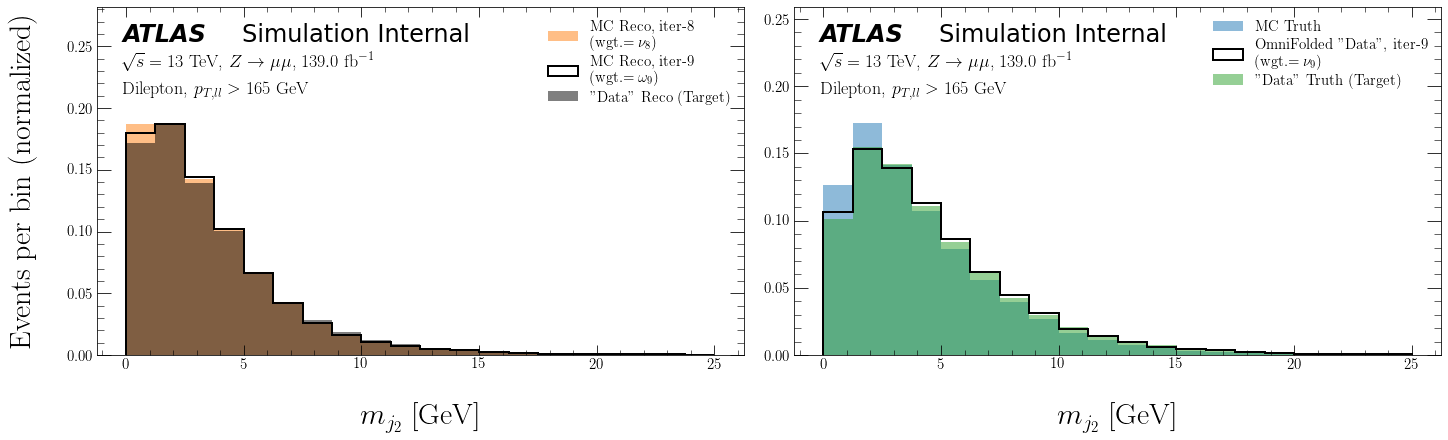

ITERATION 10:


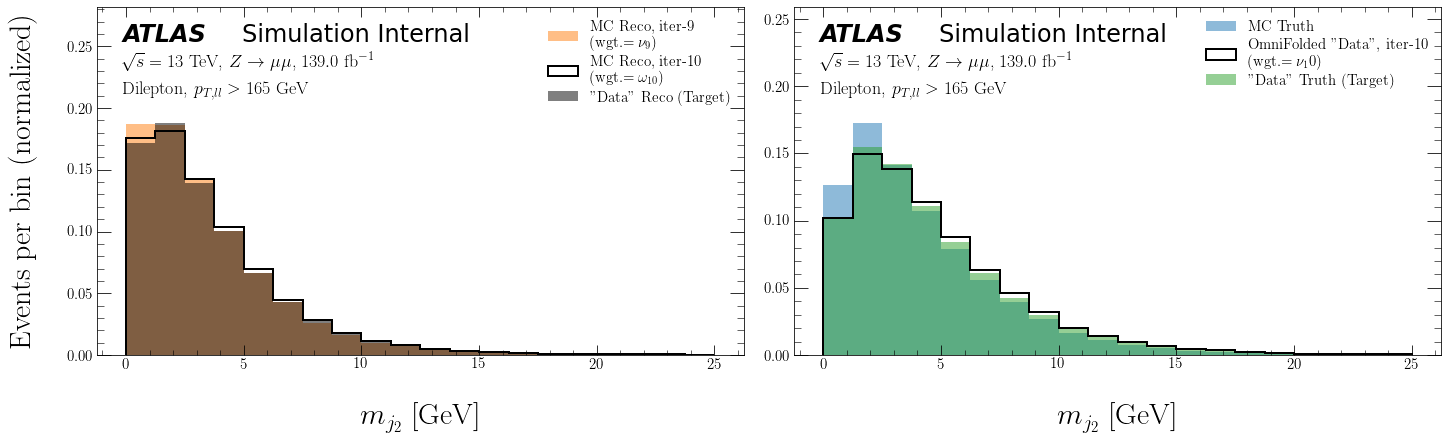

Ntracks_trackj2 Results

ITERATION 1:


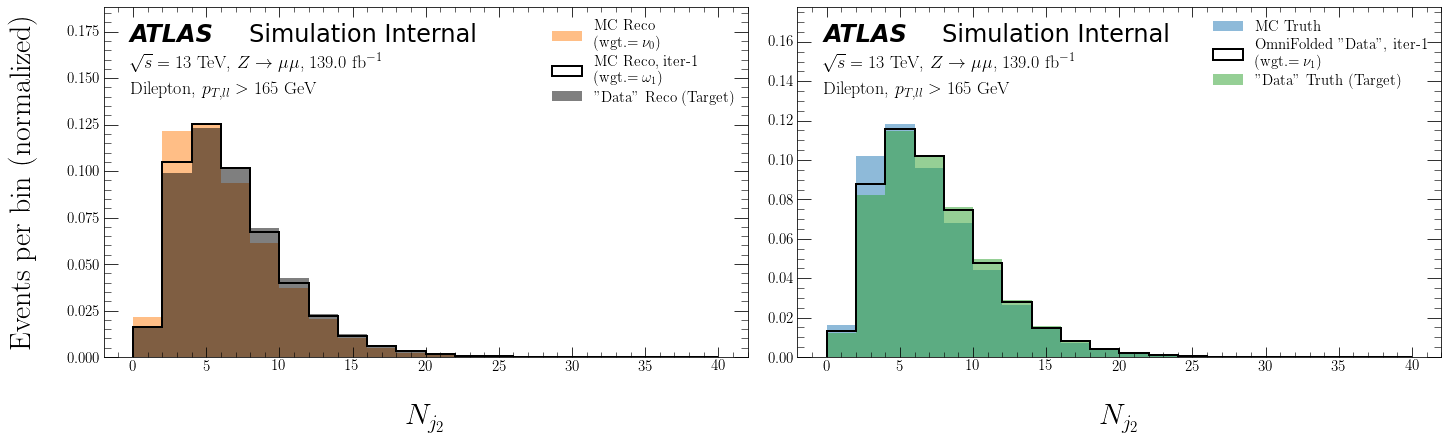

ITERATION 2:


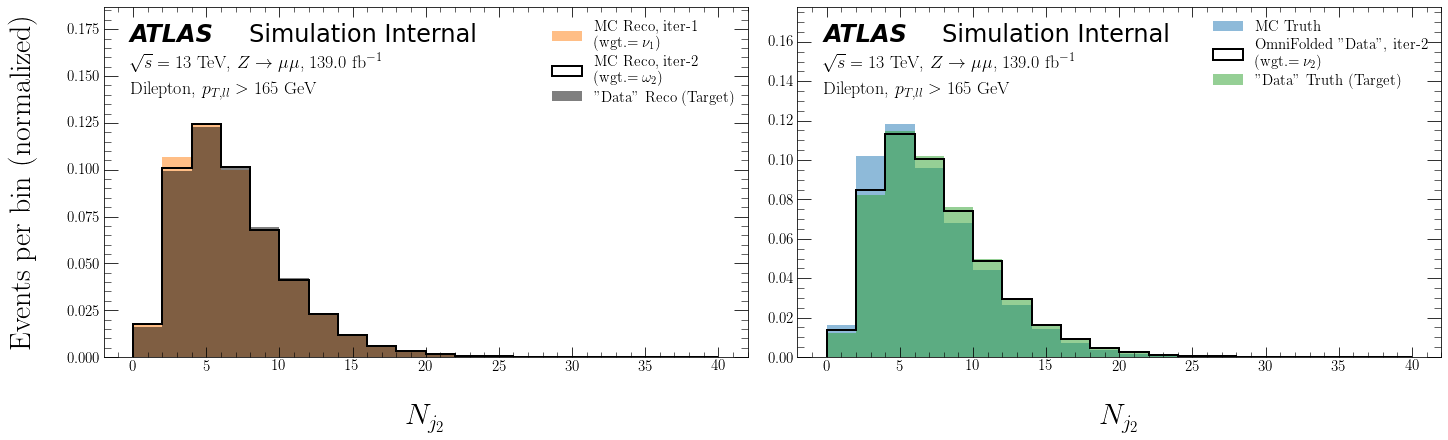

ITERATION 3:


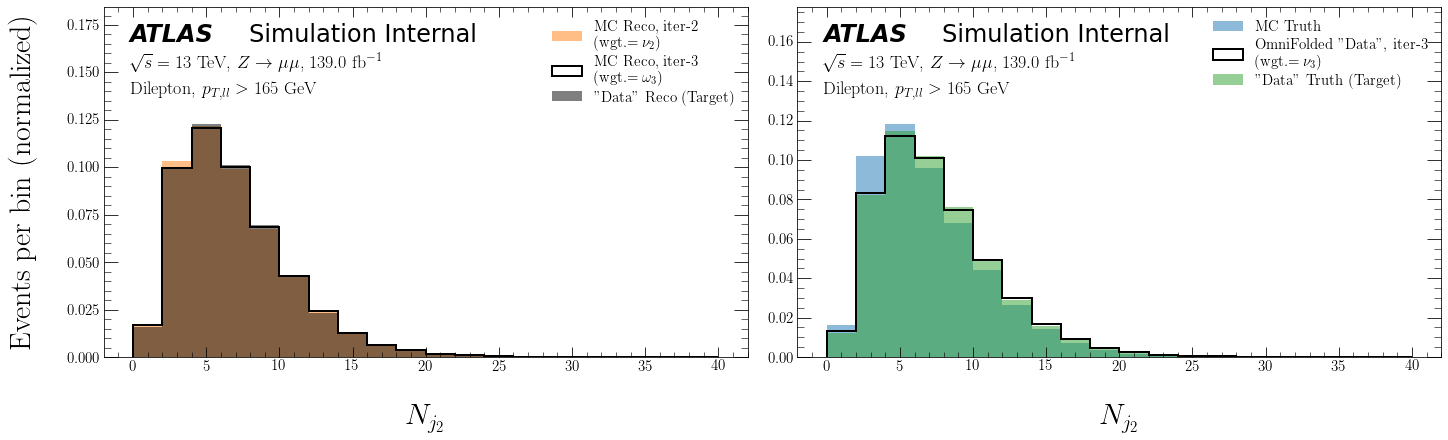

ITERATION 4:


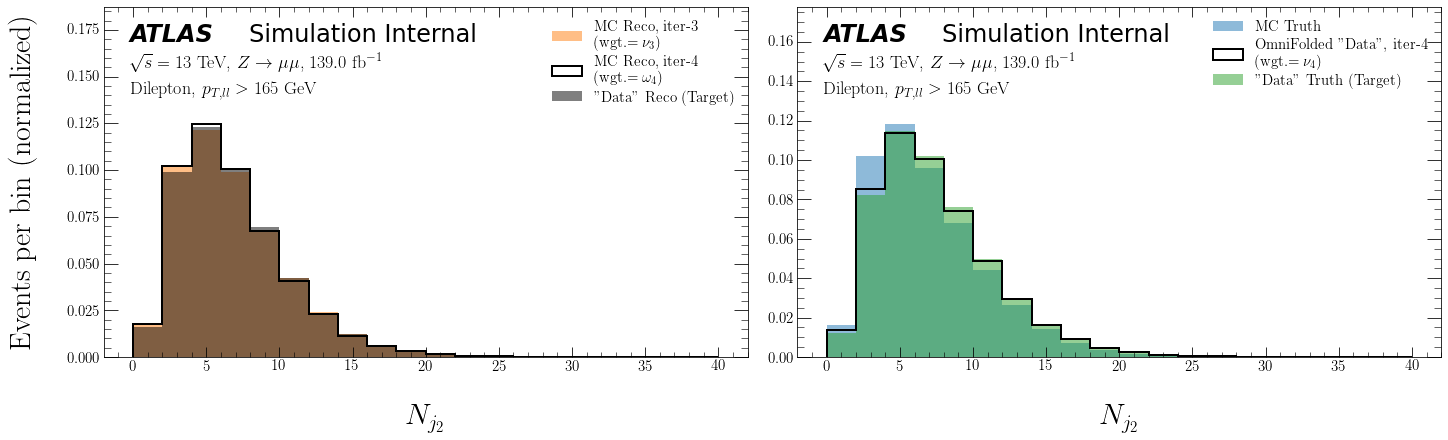

ITERATION 5:


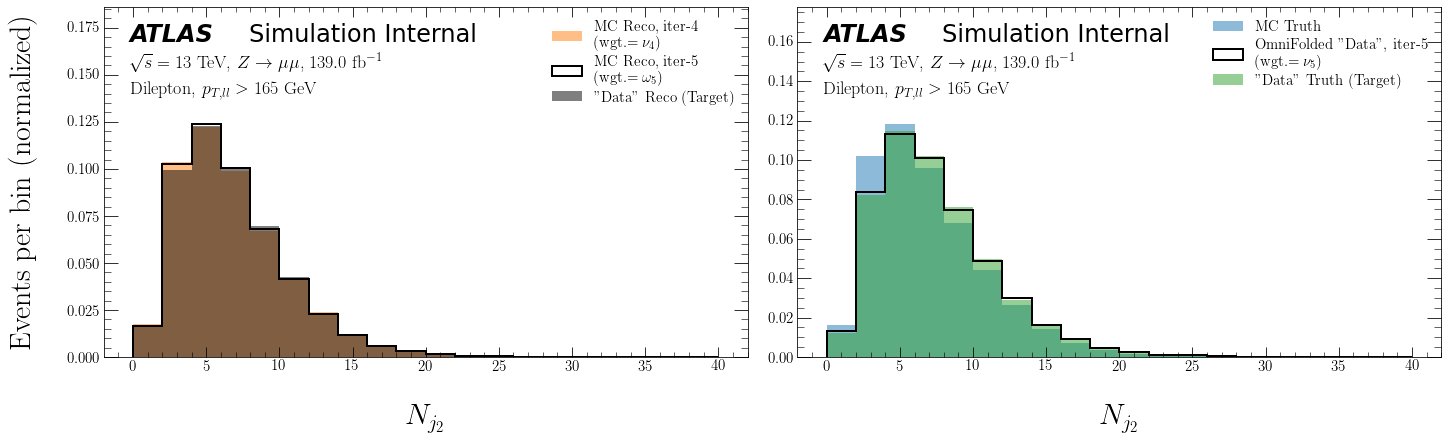

ITERATION 6:


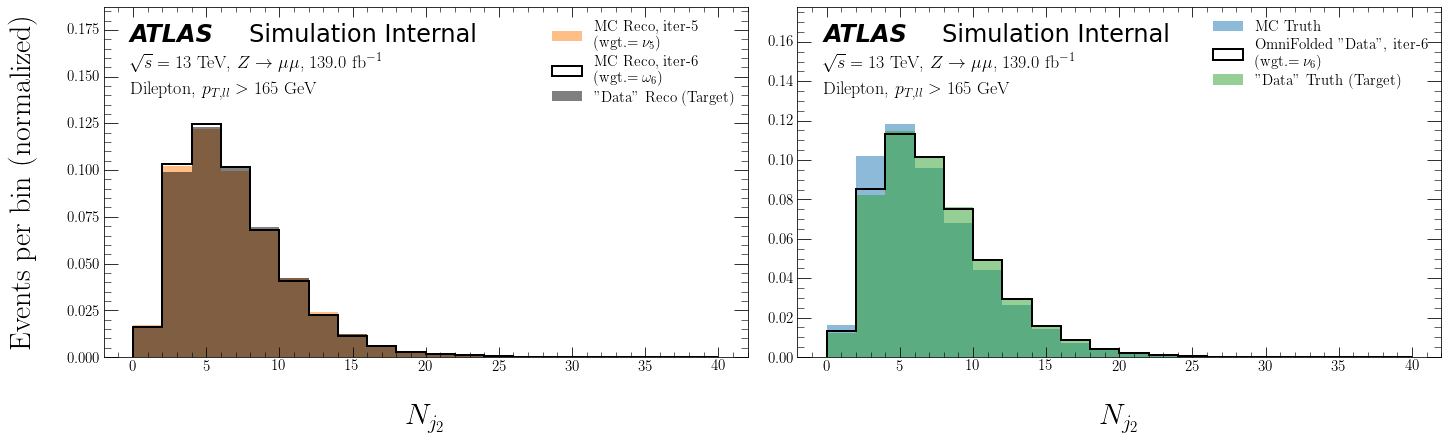

ITERATION 7:


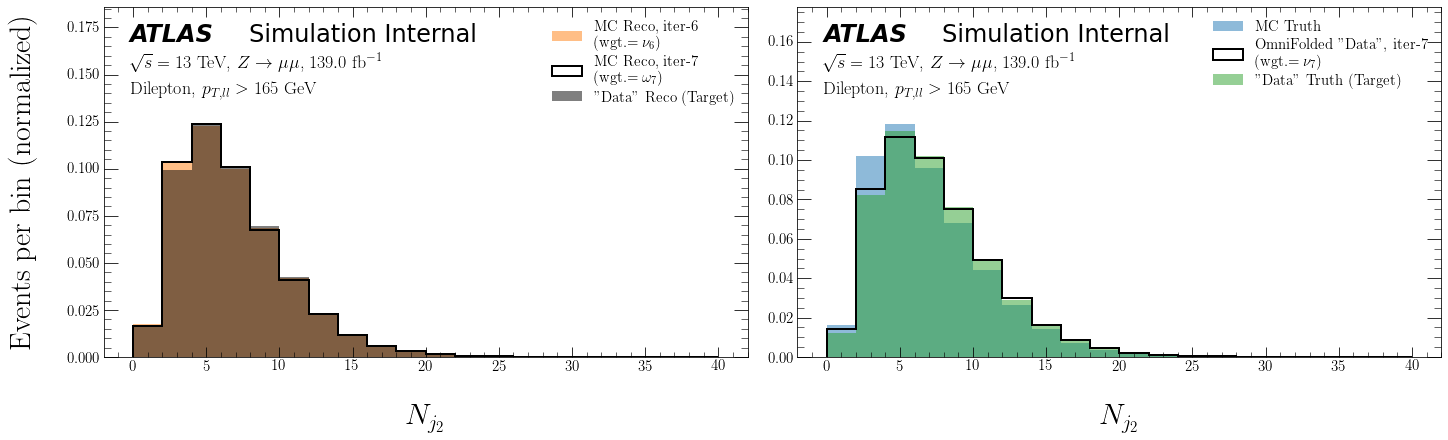

ITERATION 8:


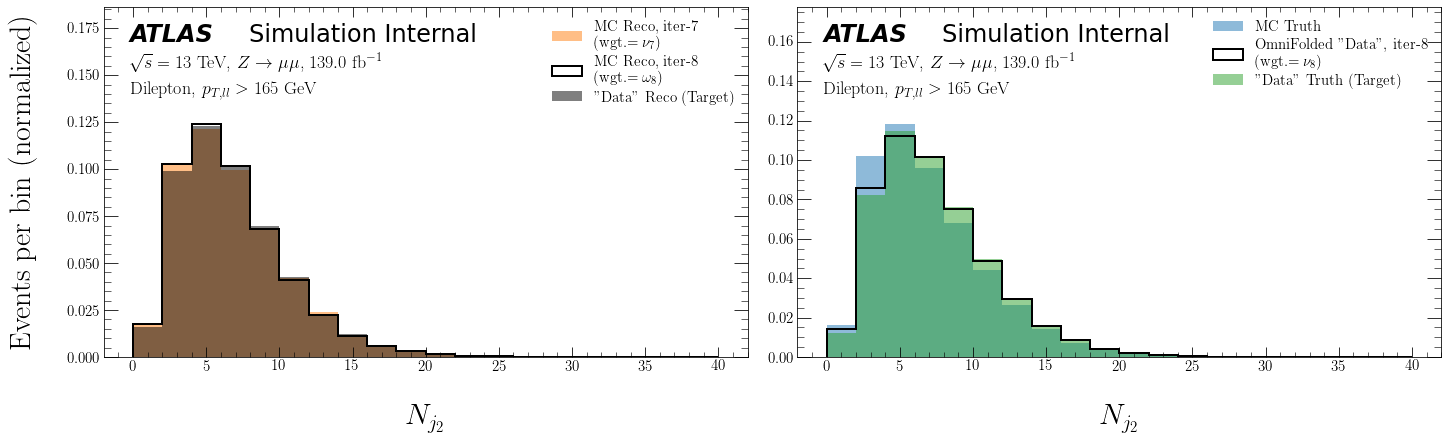

ITERATION 9:


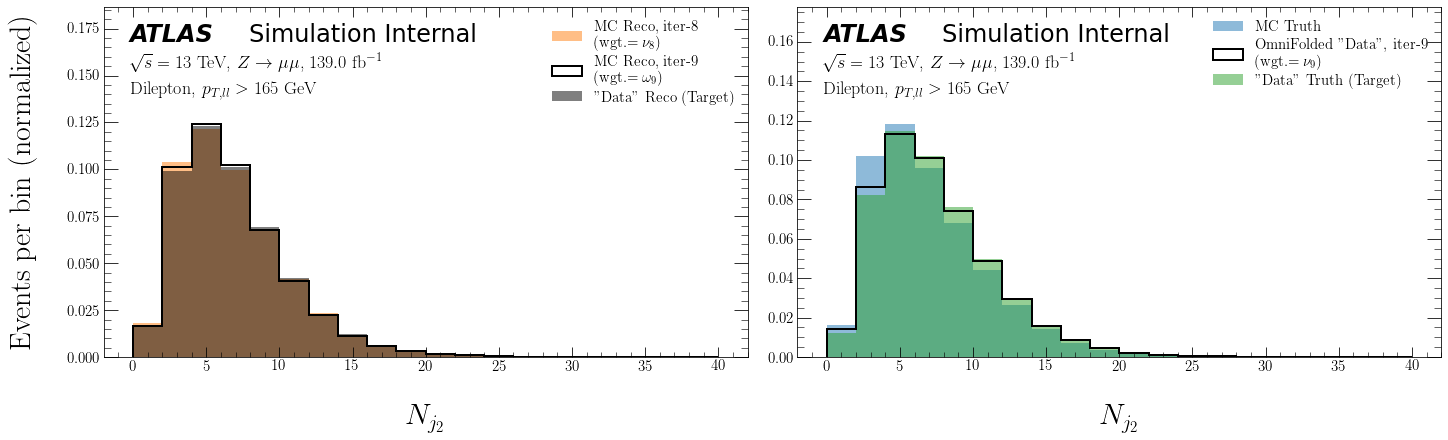

ITERATION 10:


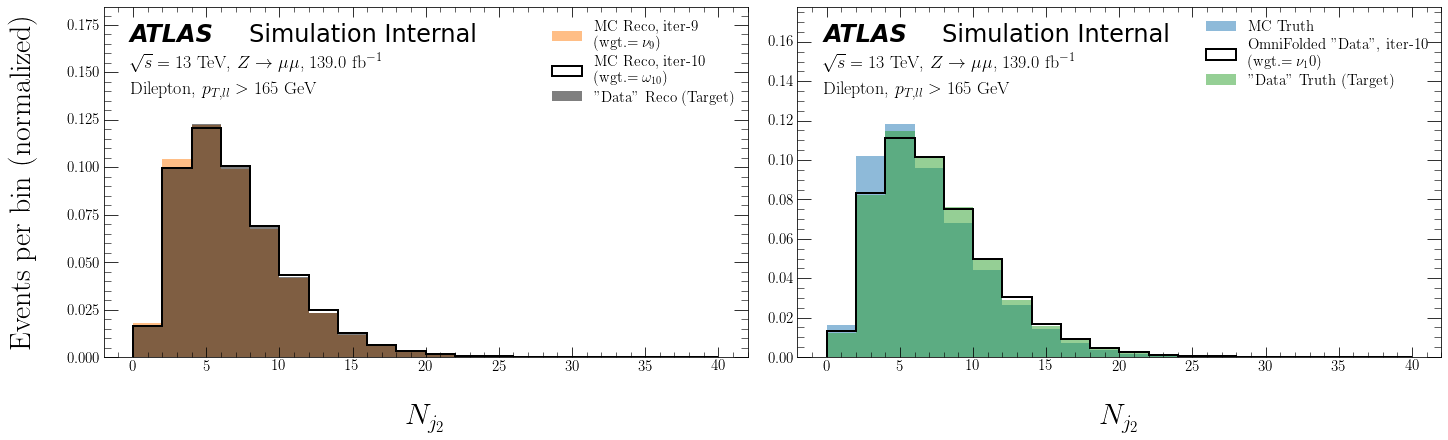

tau1_trackj2 Results

ITERATION 1:


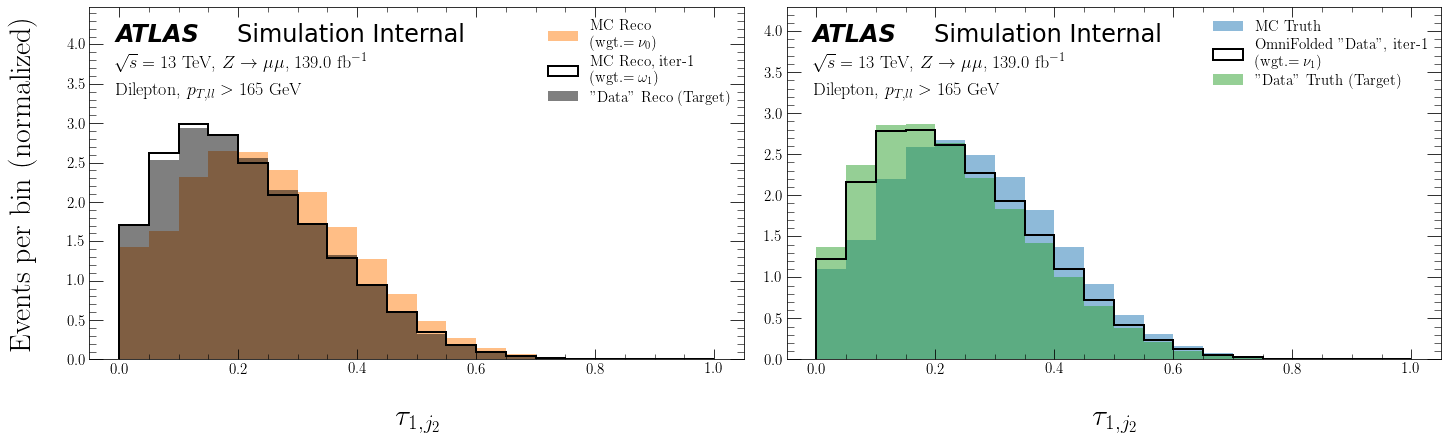

ITERATION 2:


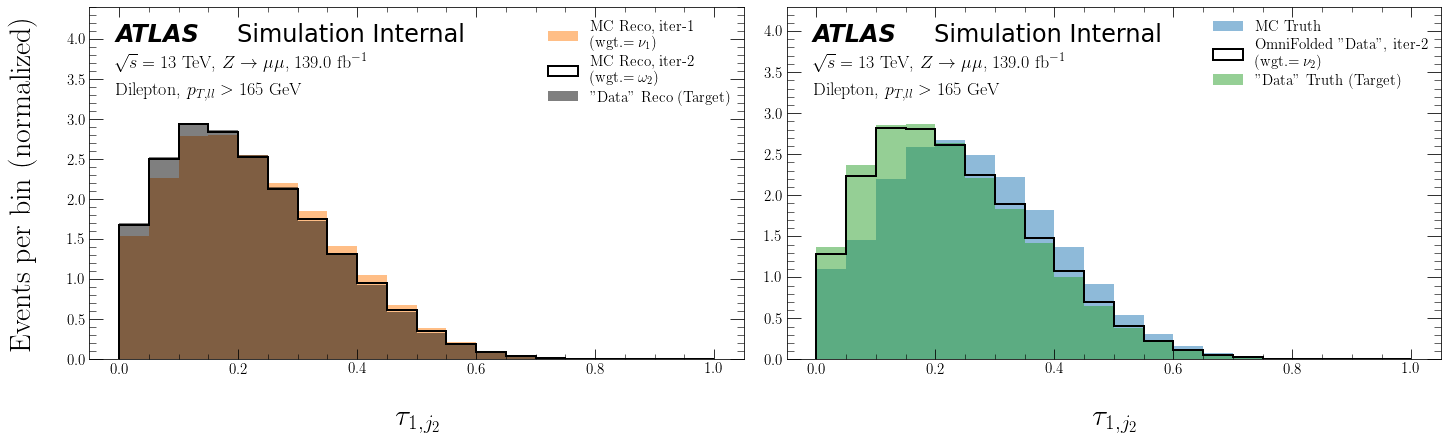

ITERATION 3:


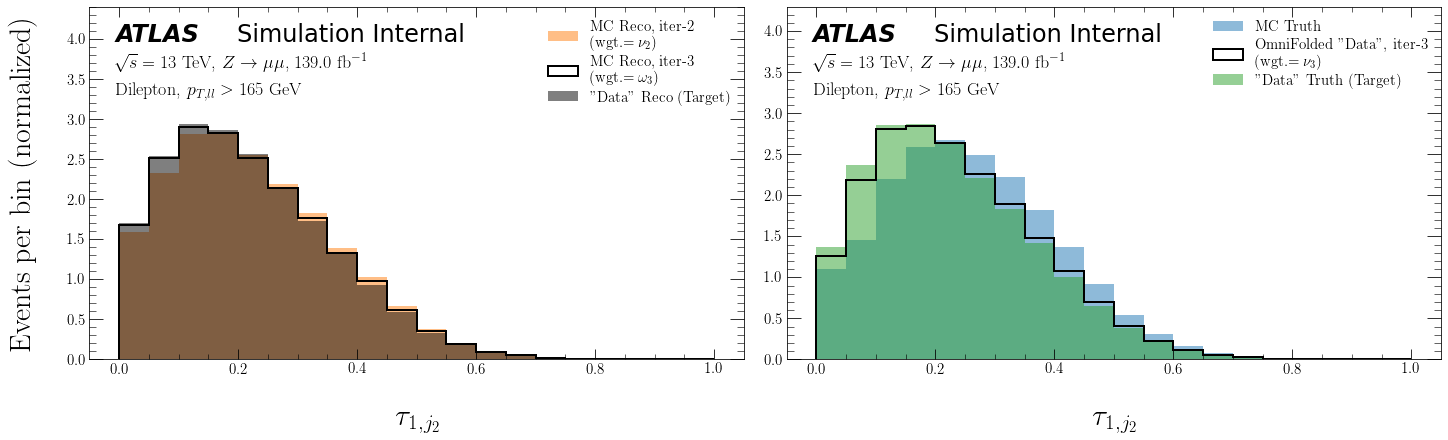

ITERATION 4:


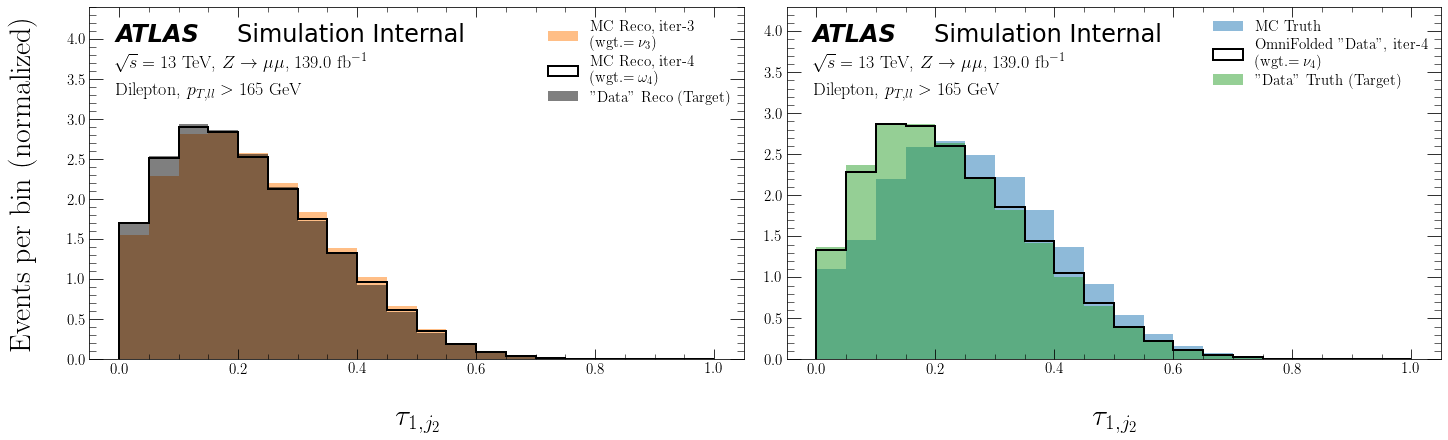

ITERATION 5:


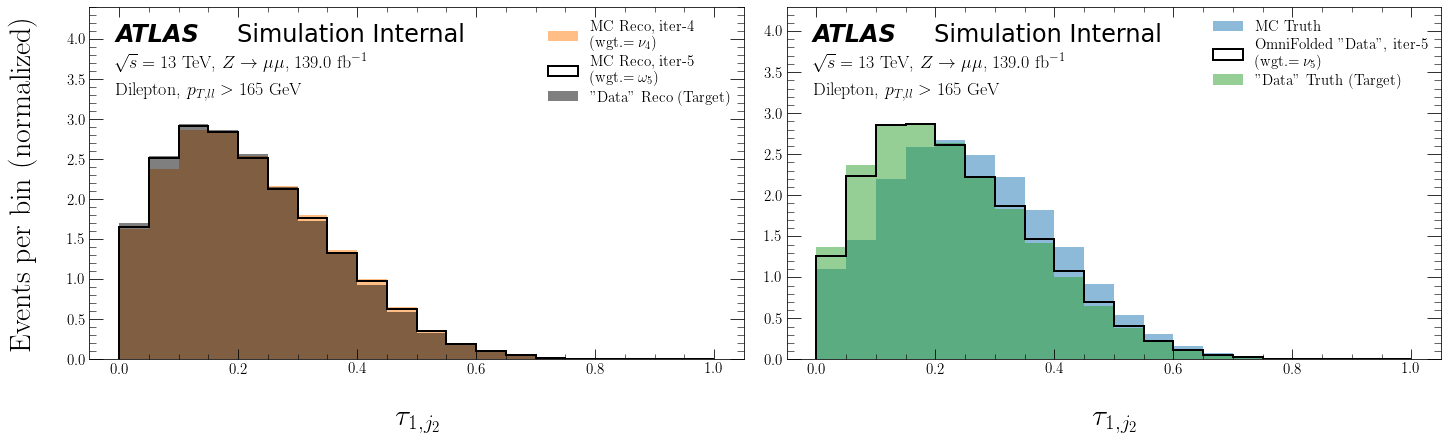

ITERATION 6:


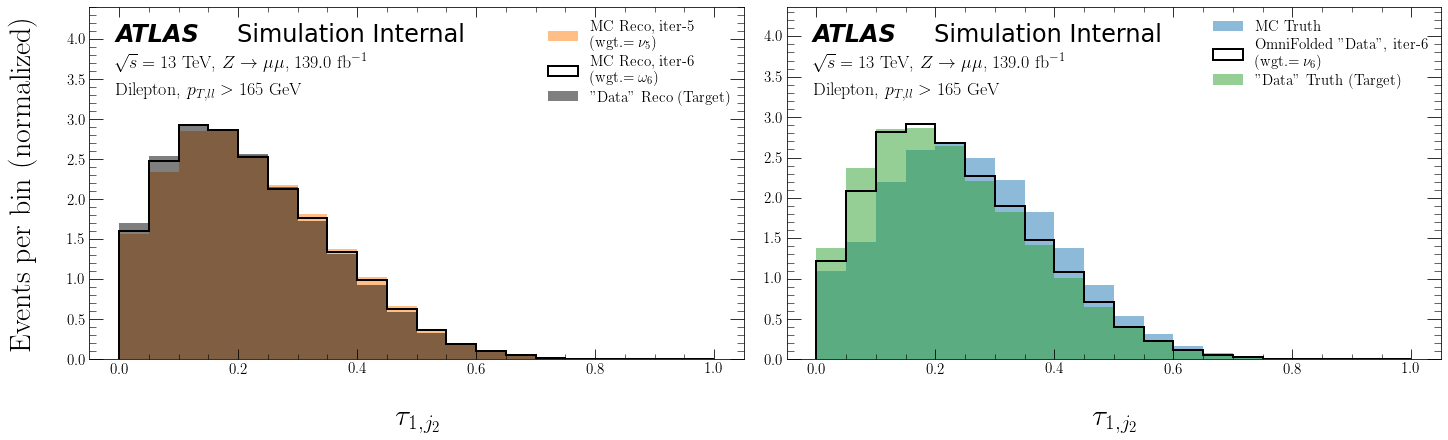

ITERATION 7:


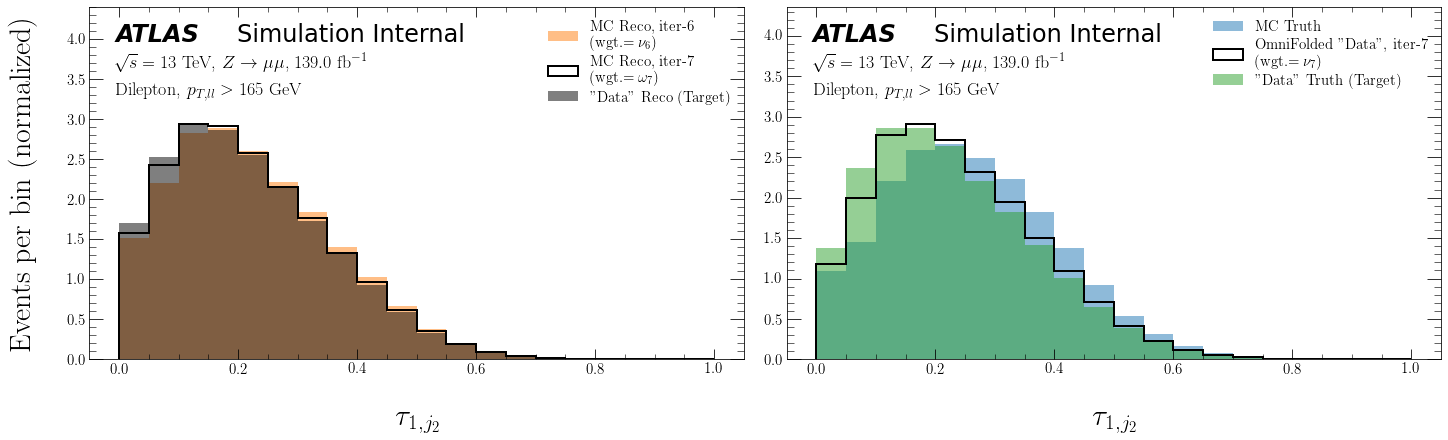

ITERATION 8:


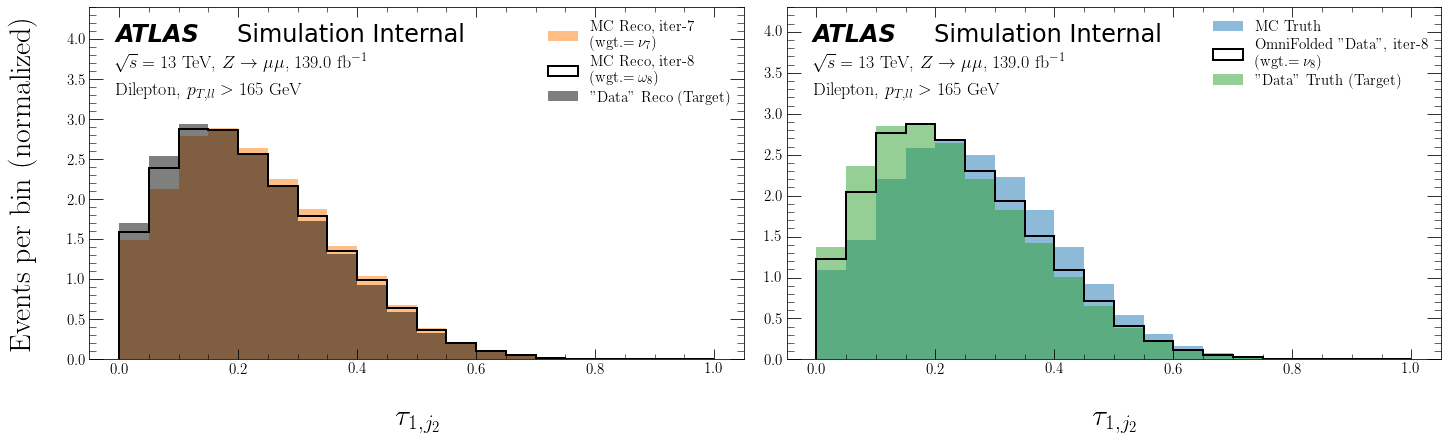

ITERATION 9:


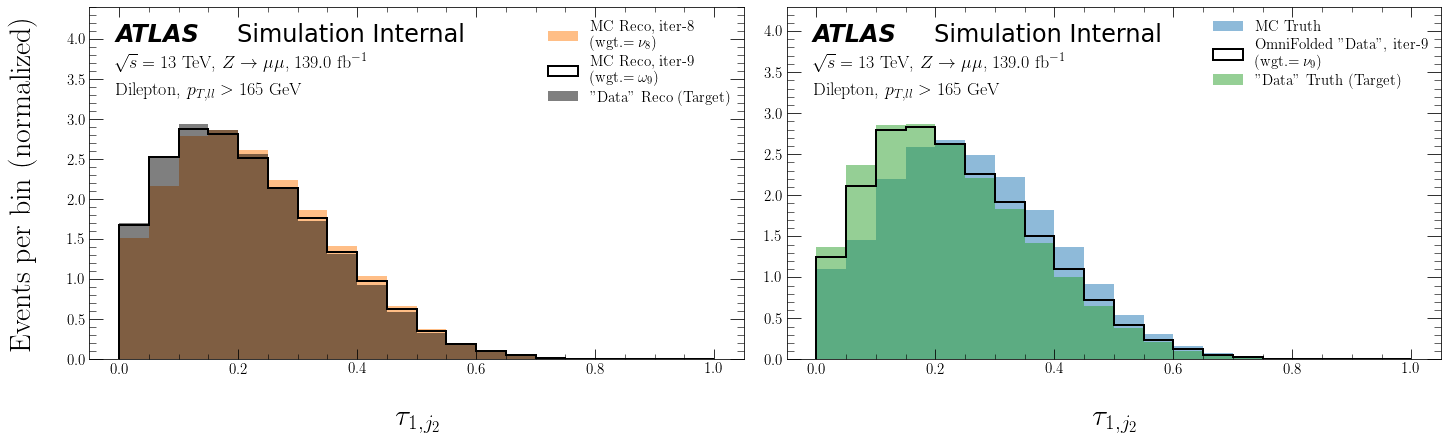

ITERATION 10:


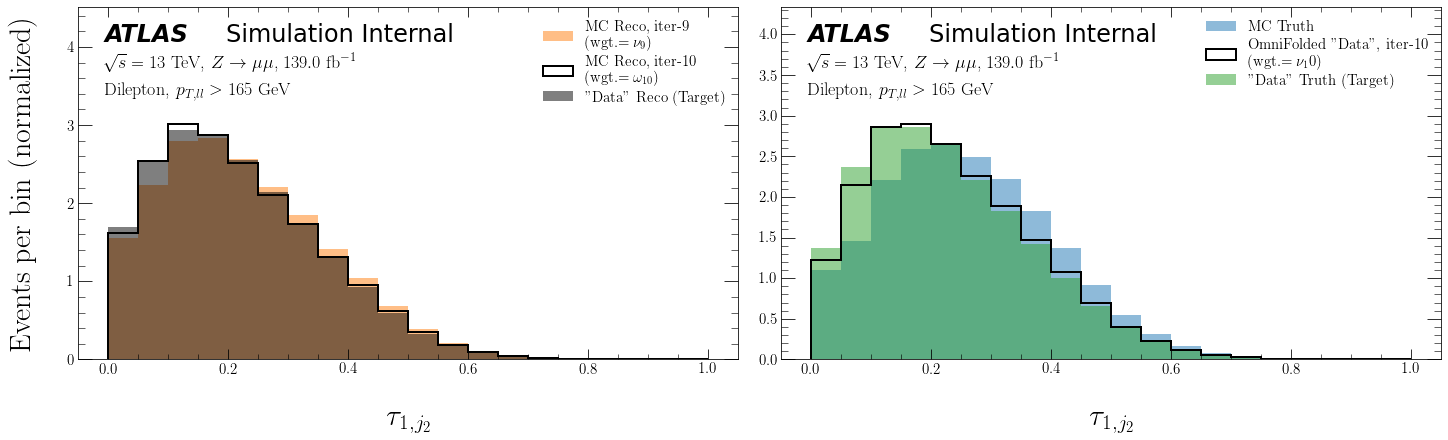

pT_trackj2 Results

ITERATION 1:


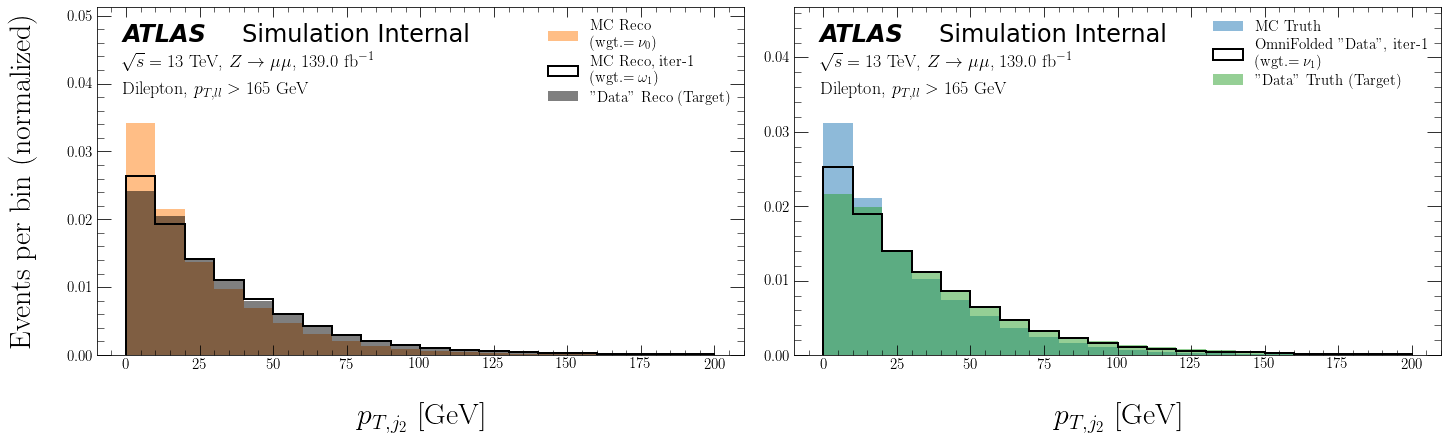

ITERATION 2:


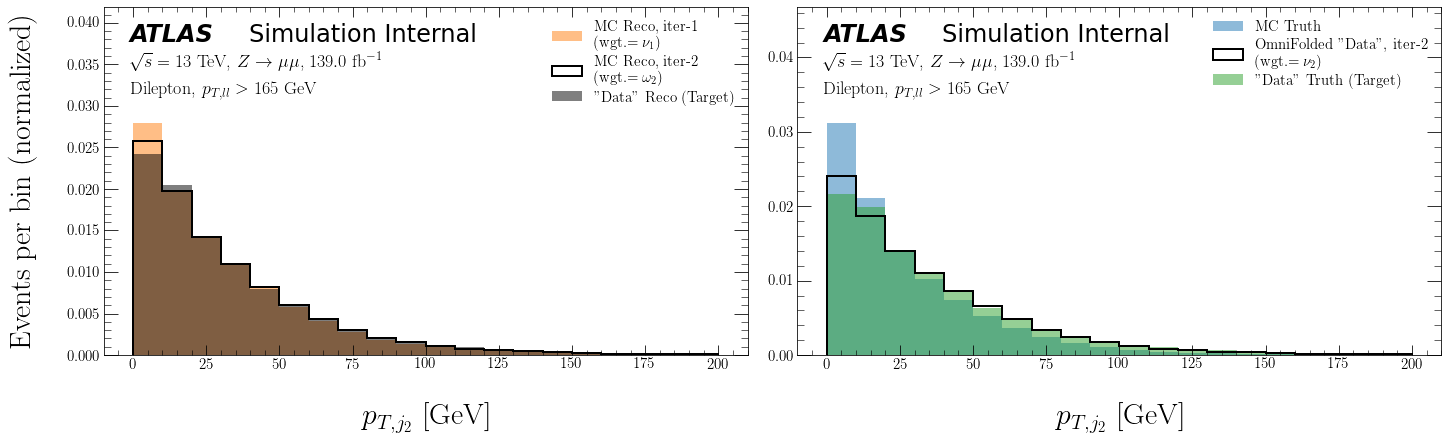

ITERATION 3:


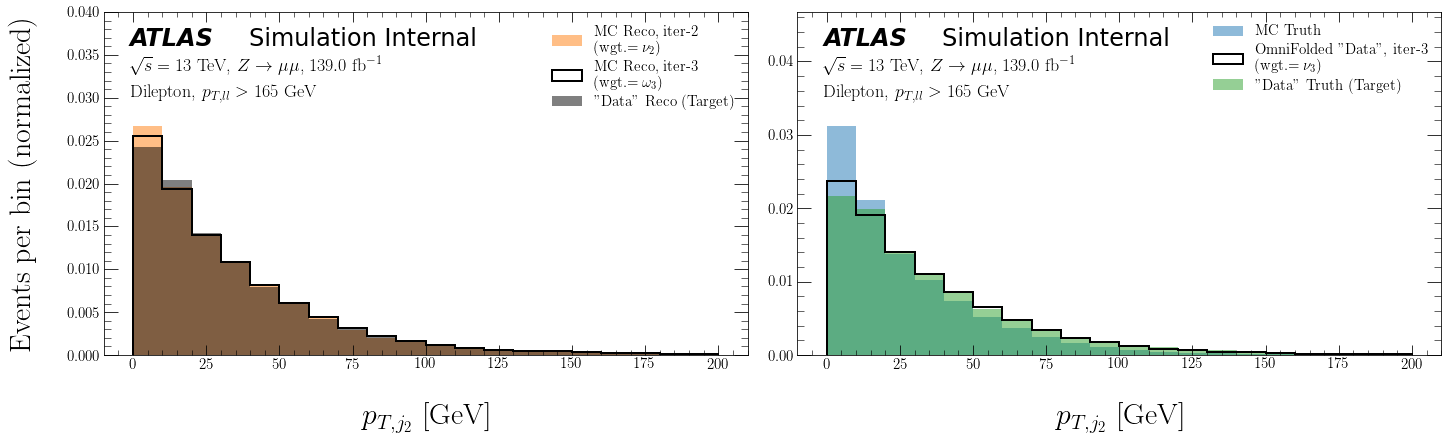

ITERATION 4:


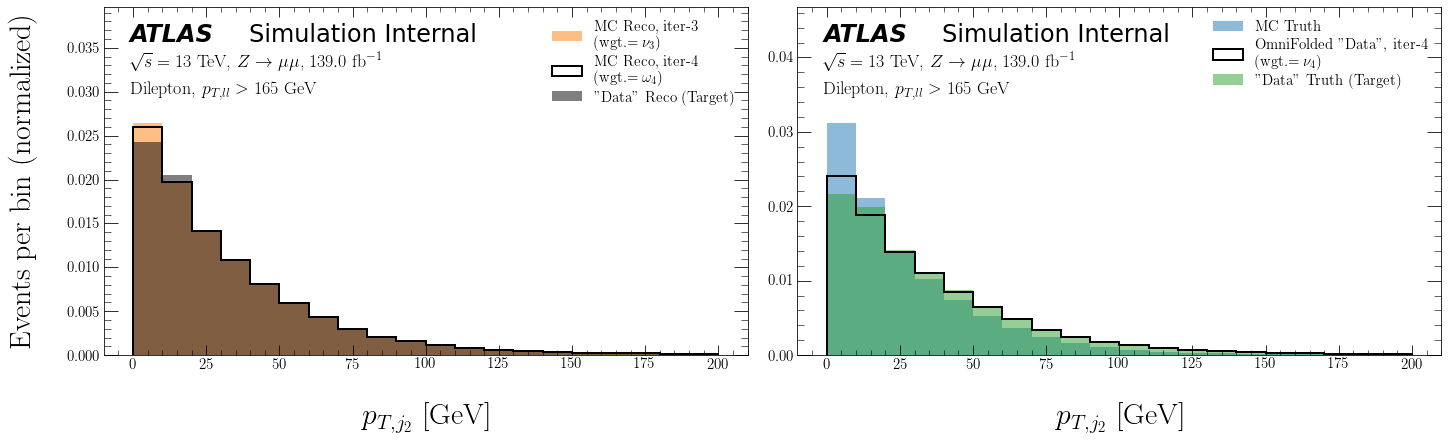

ITERATION 5:


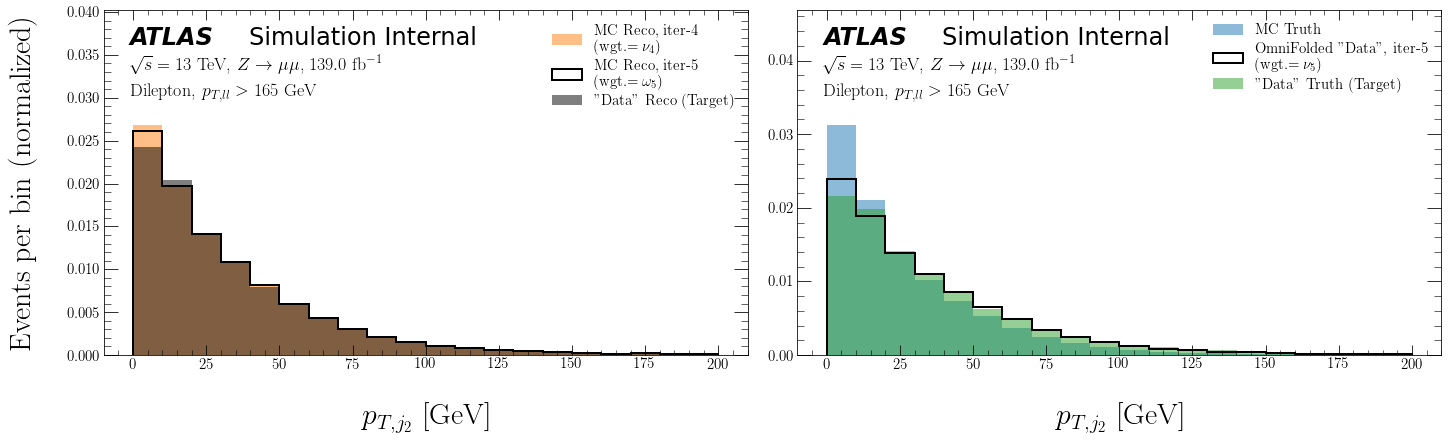

ITERATION 6:


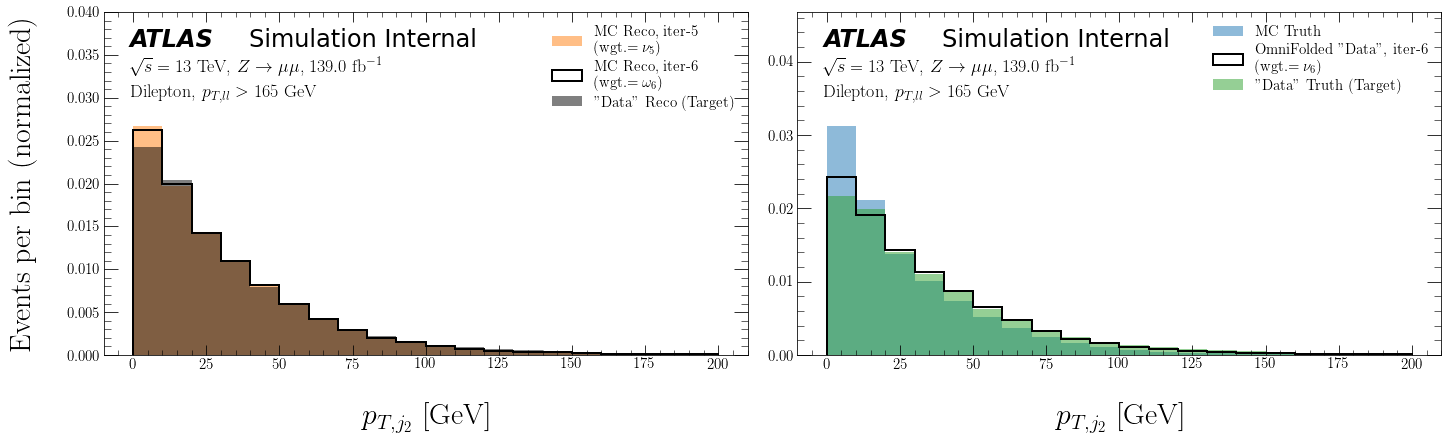

ITERATION 7:


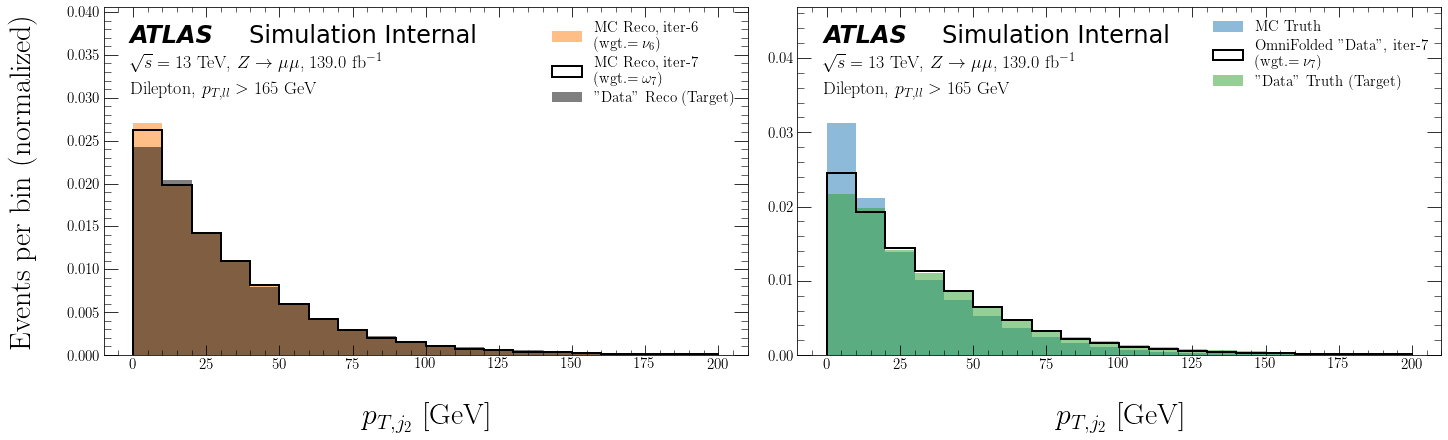

ITERATION 8:


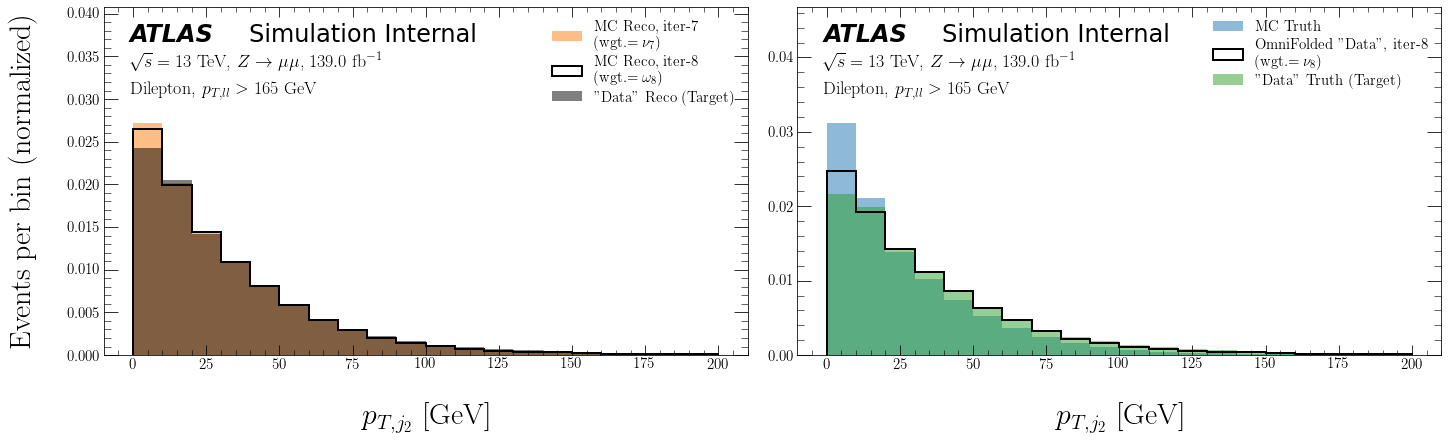

ITERATION 9:


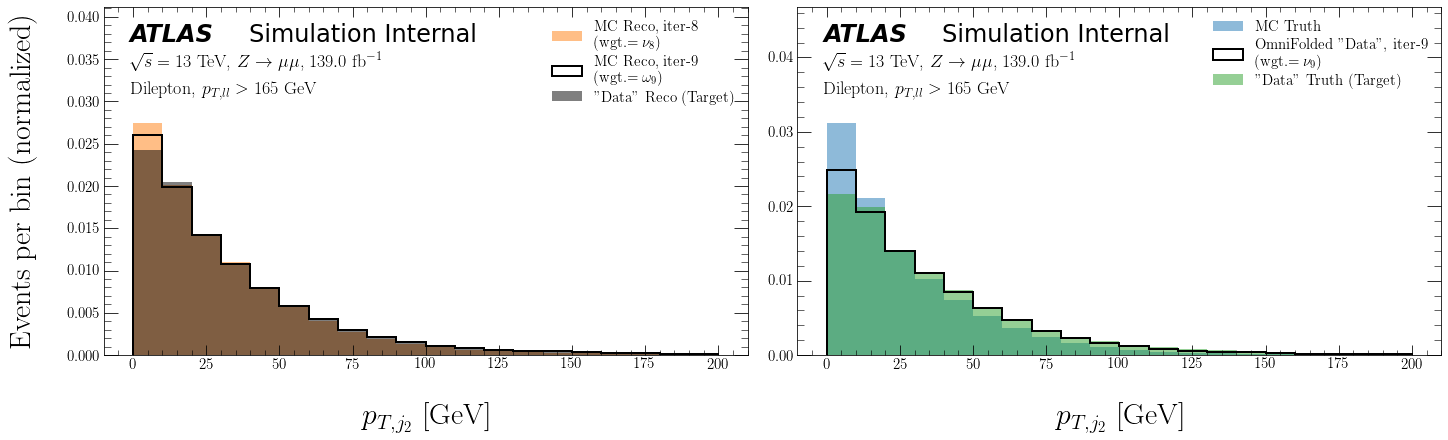

ITERATION 10:


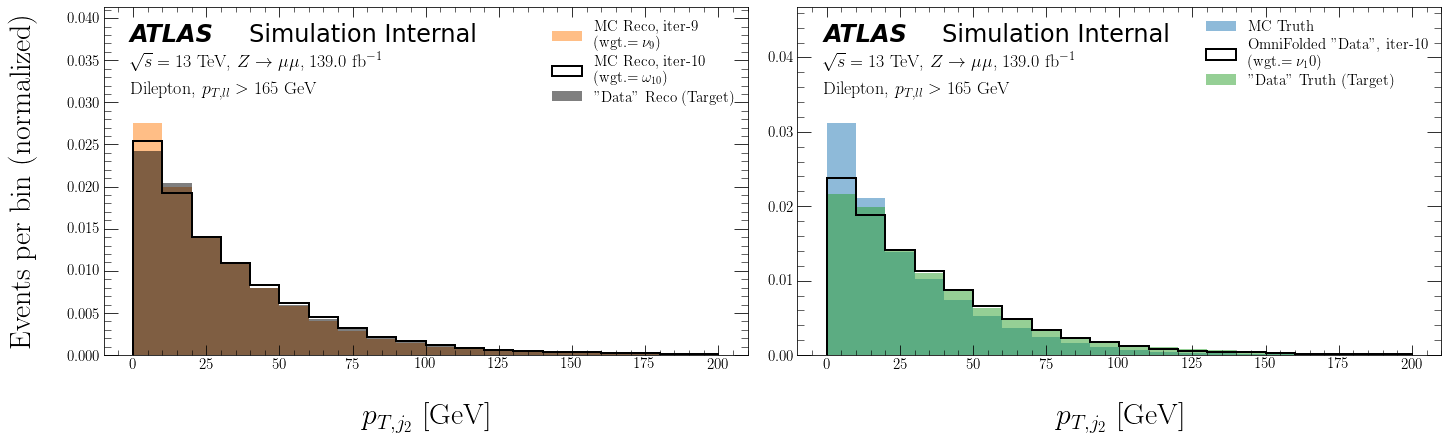

tau2_trackj2 Results

ITERATION 1:


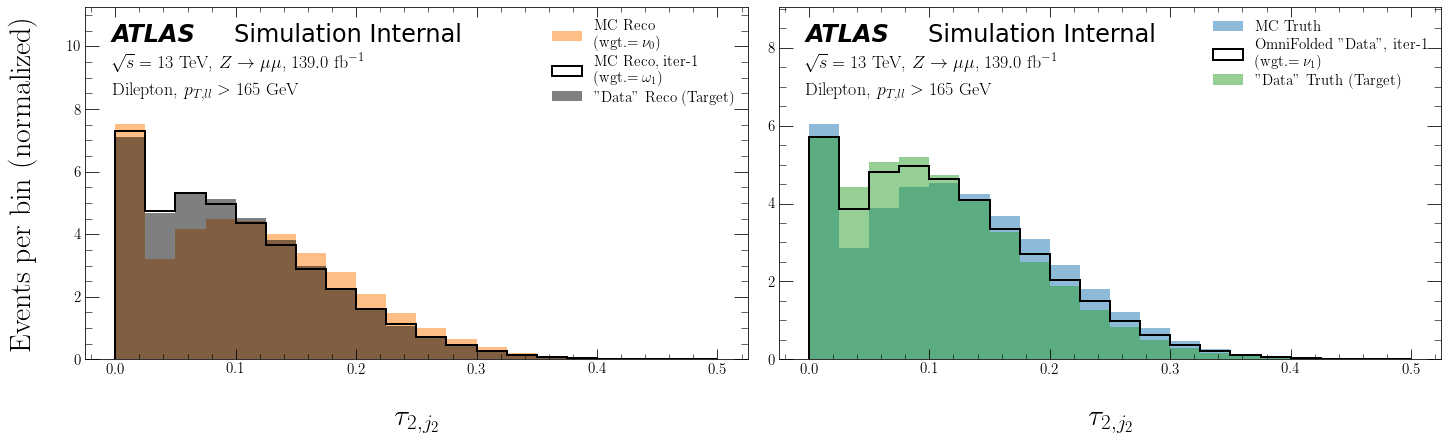

ITERATION 2:


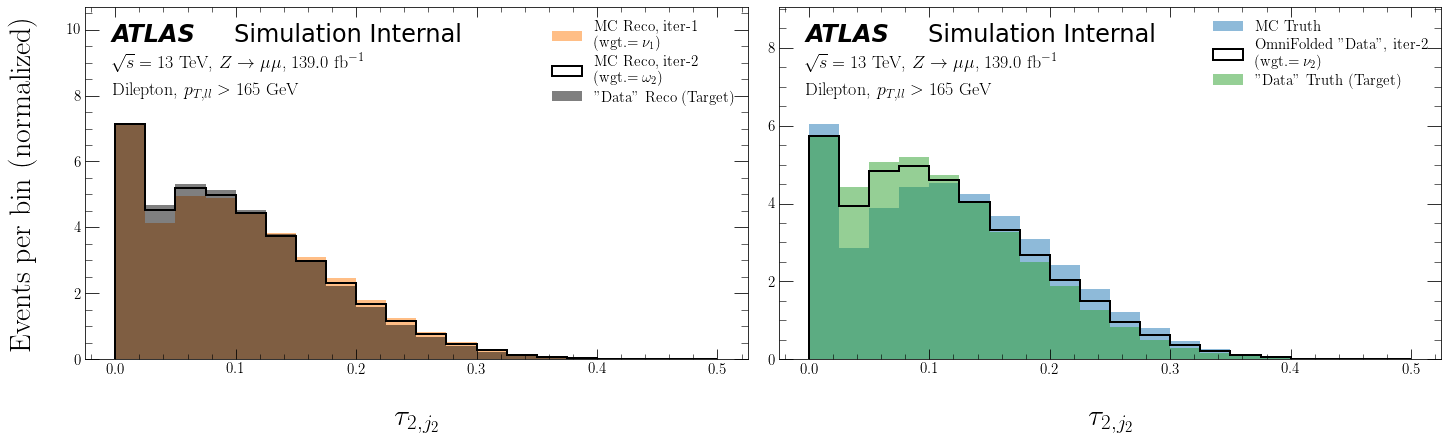

ITERATION 3:


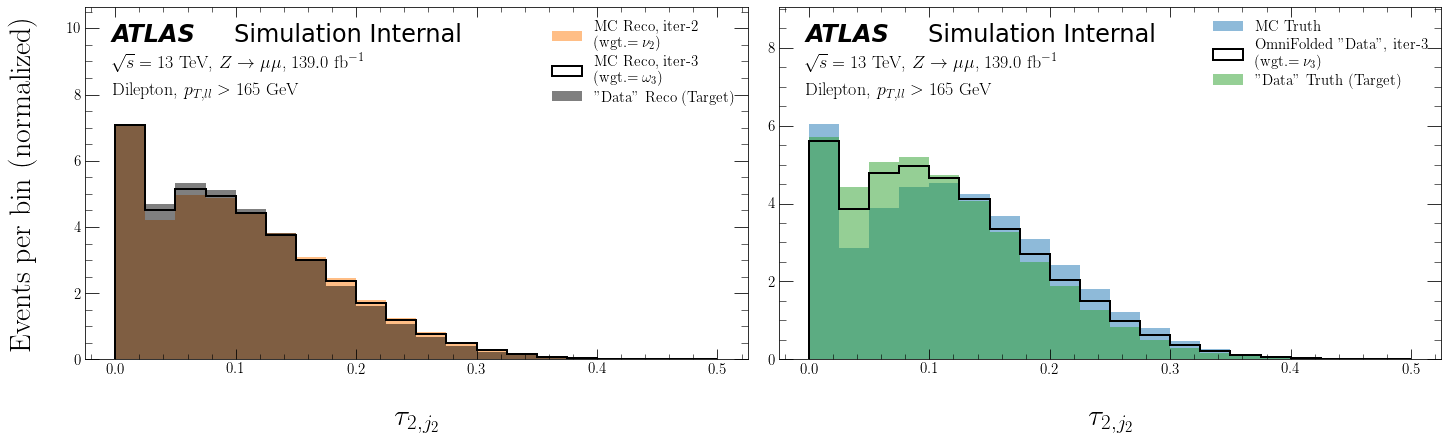

ITERATION 4:


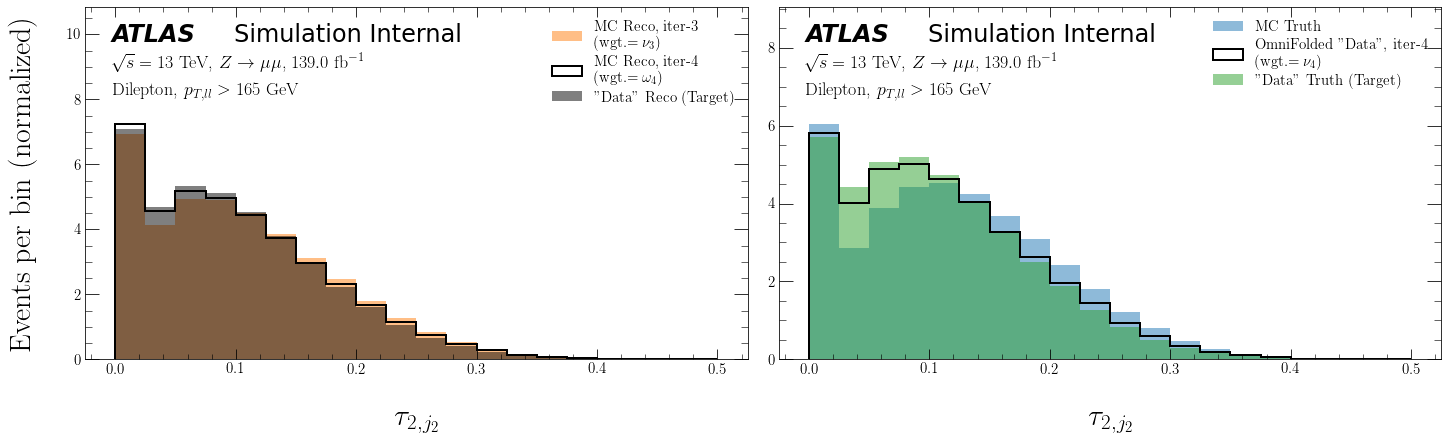

ITERATION 5:


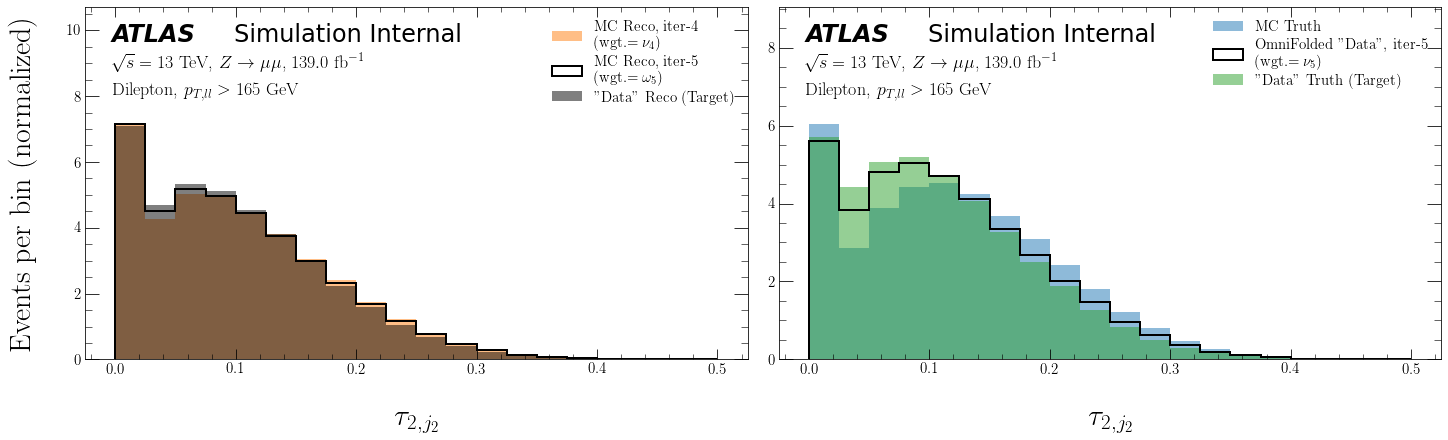

ITERATION 6:


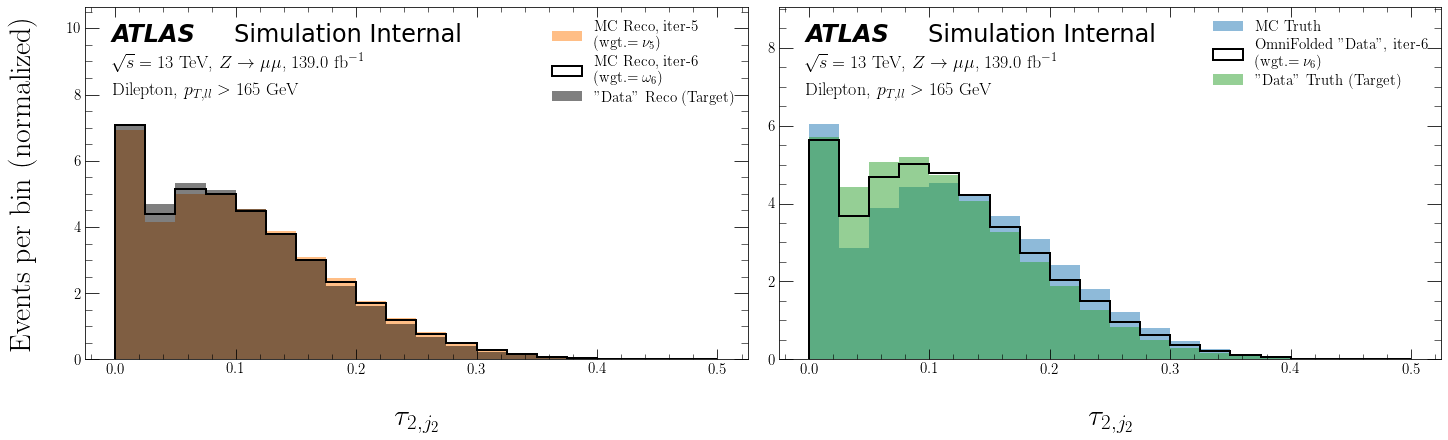

ITERATION 7:


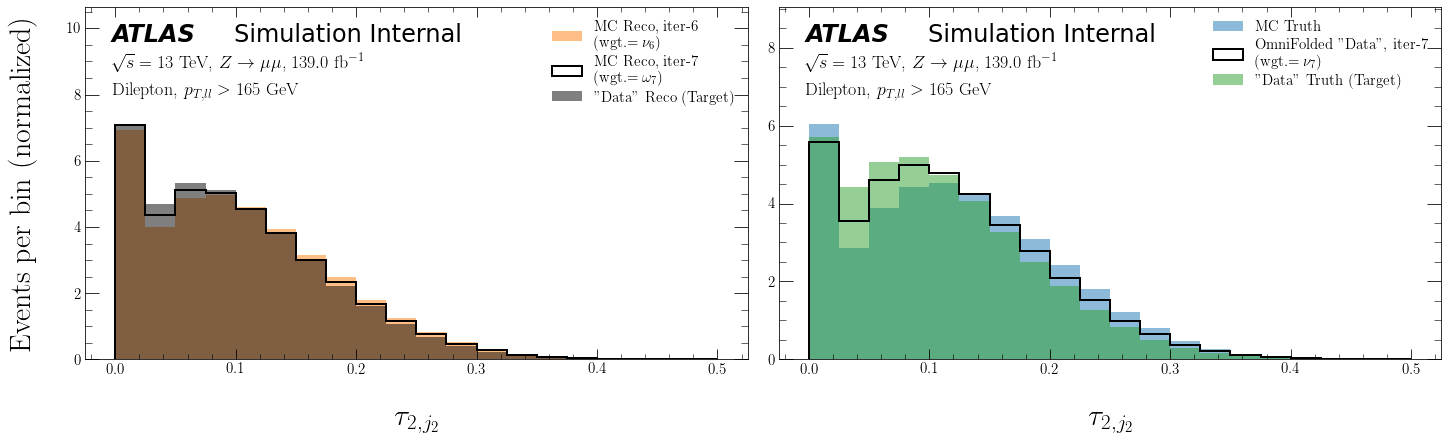

ITERATION 8:


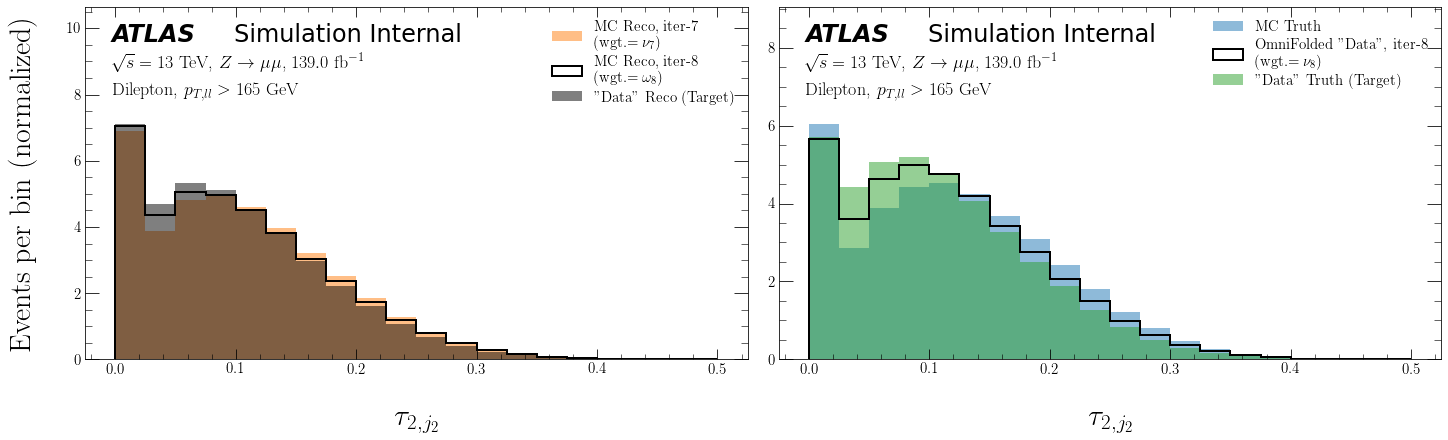

ITERATION 9:


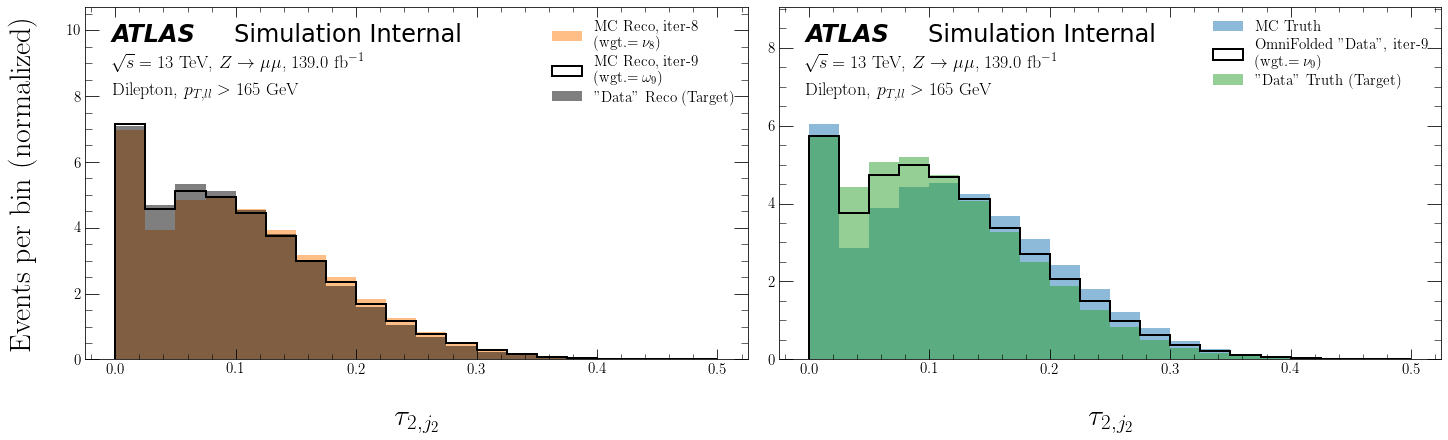

ITERATION 10:


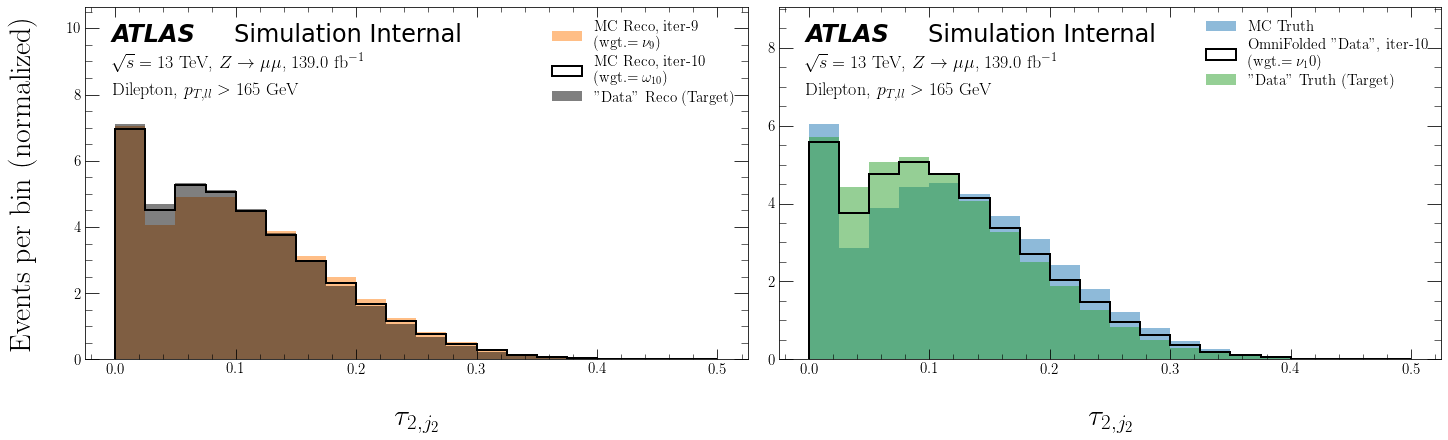

y_trackj2 Results

ITERATION 1:


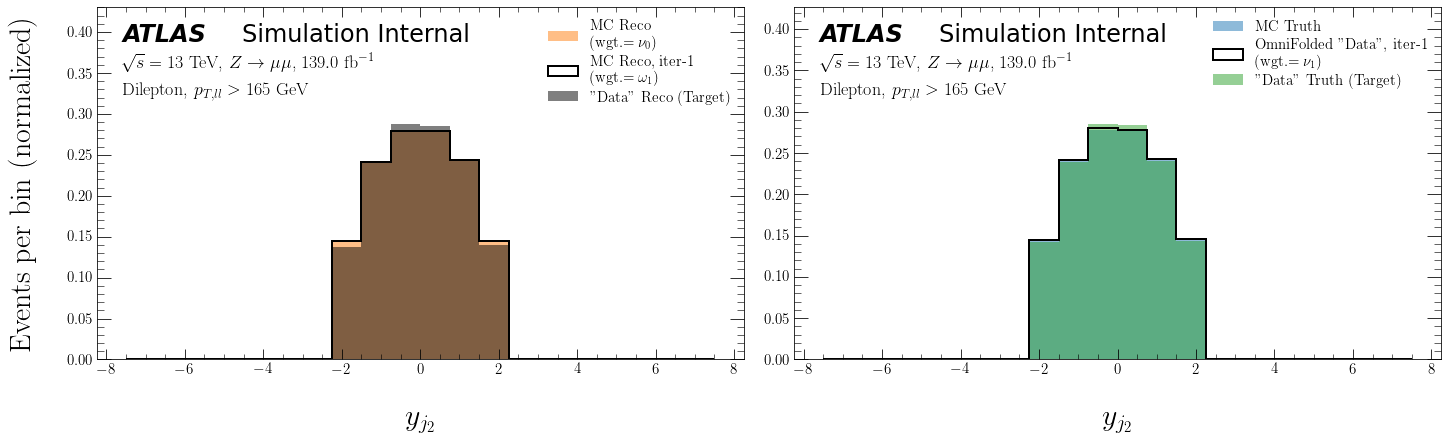

ITERATION 2:


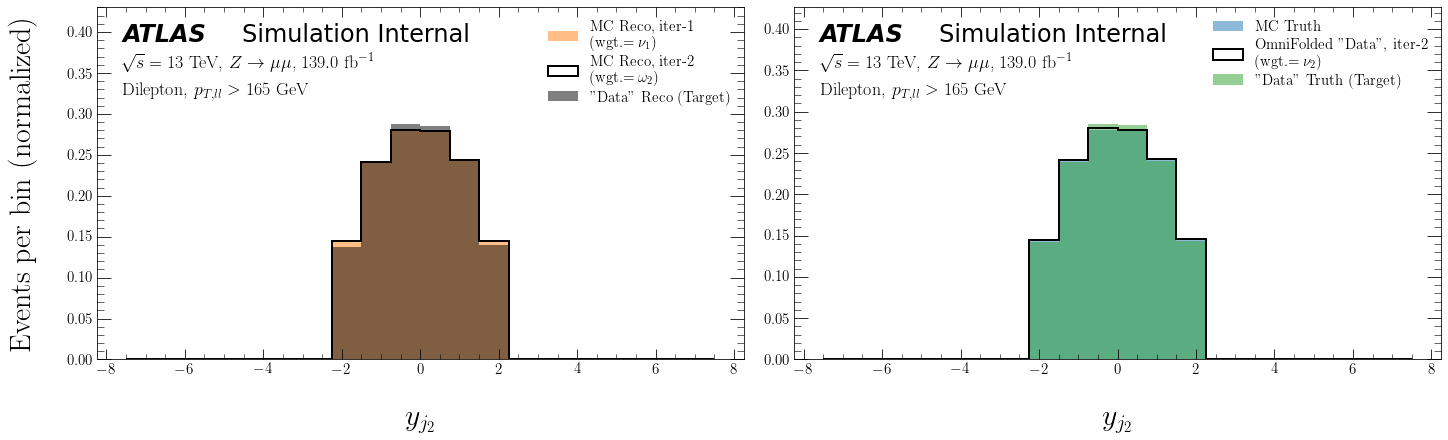

ITERATION 3:


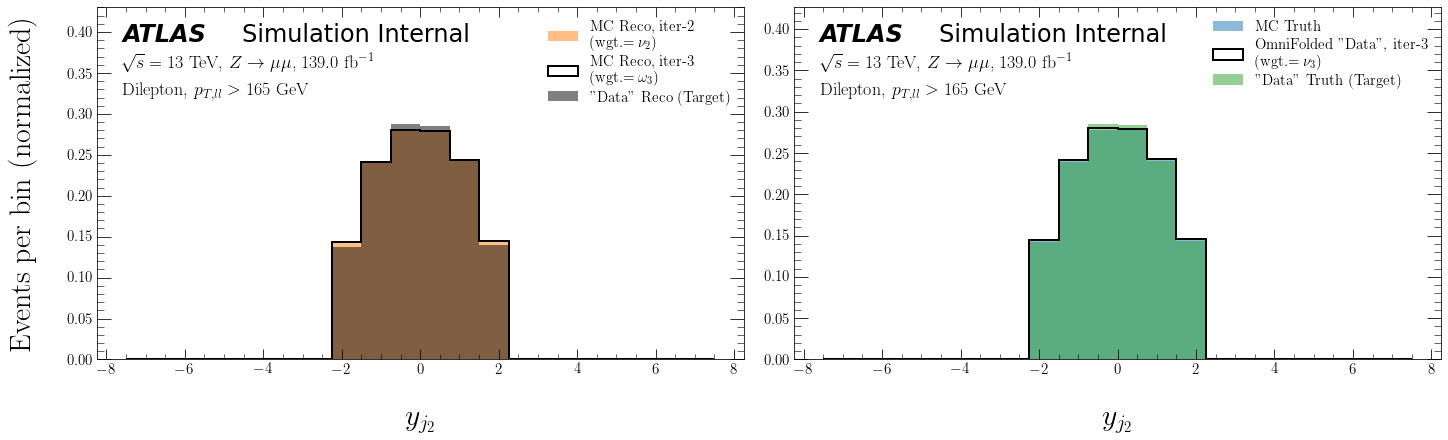

ITERATION 4:


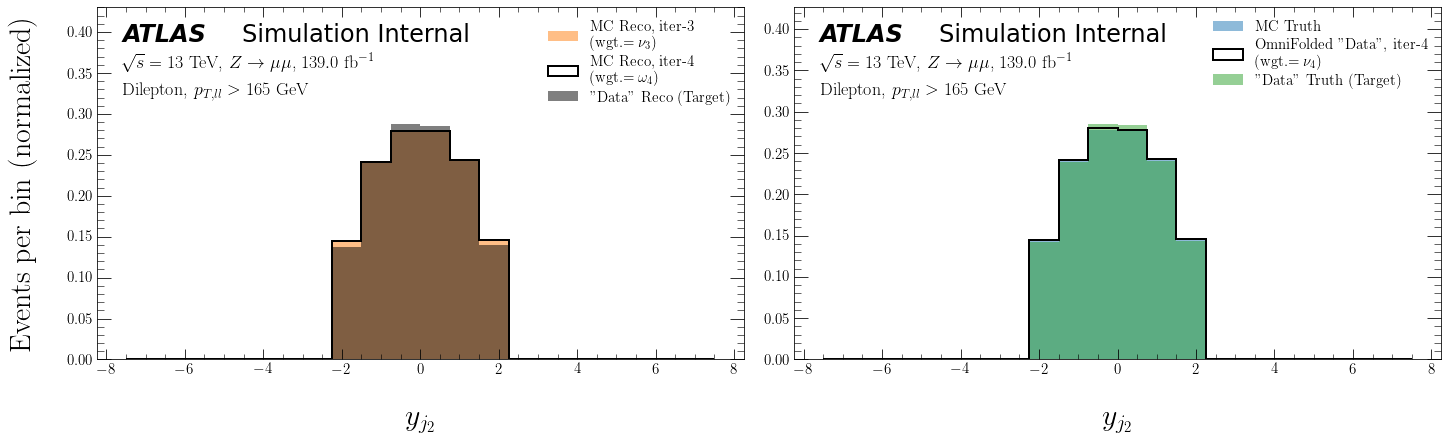

ITERATION 5:


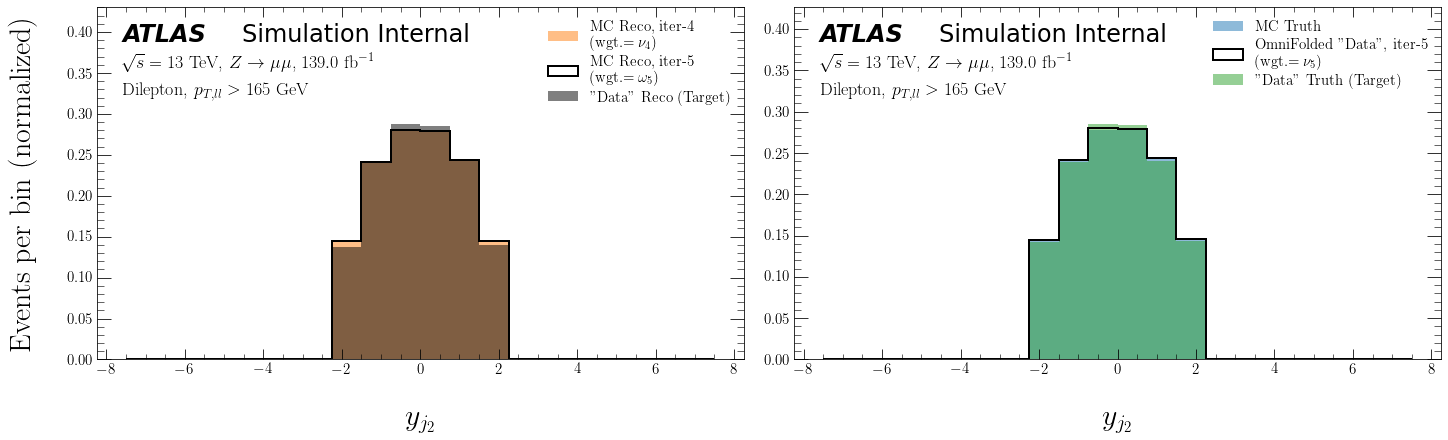

ITERATION 6:


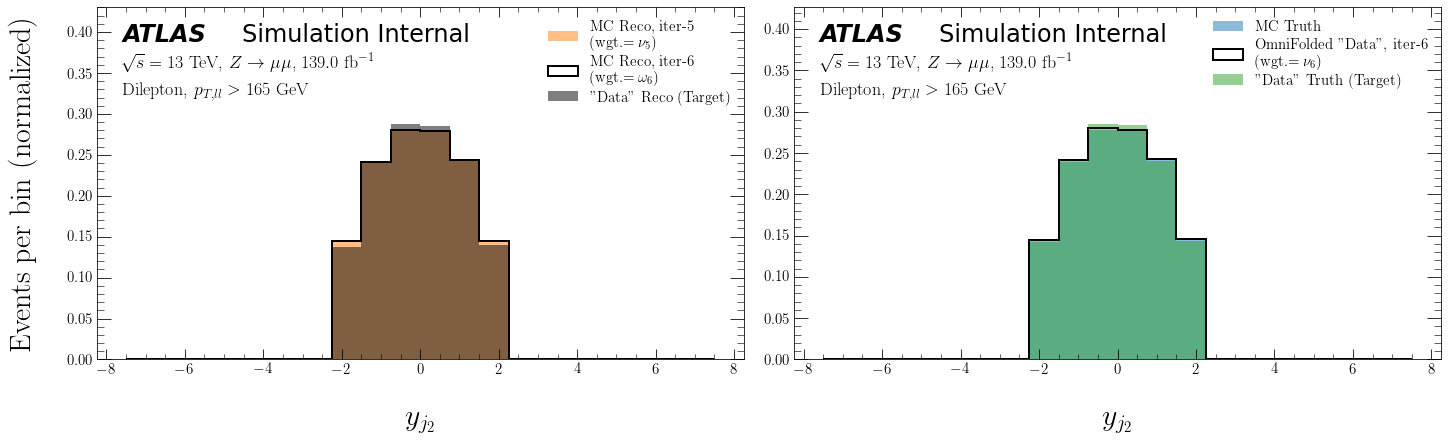

ITERATION 7:


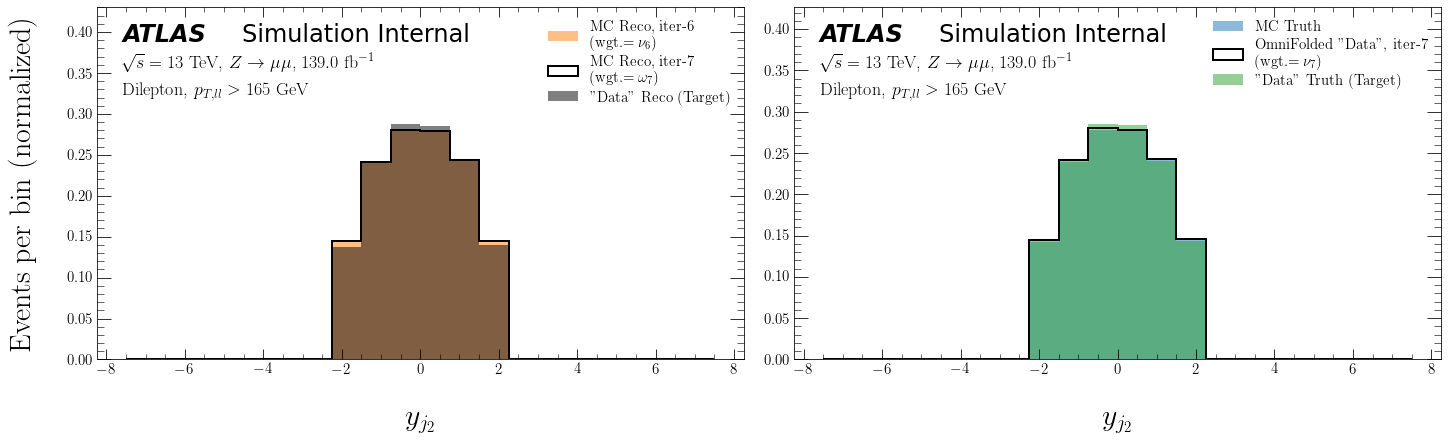

ITERATION 8:


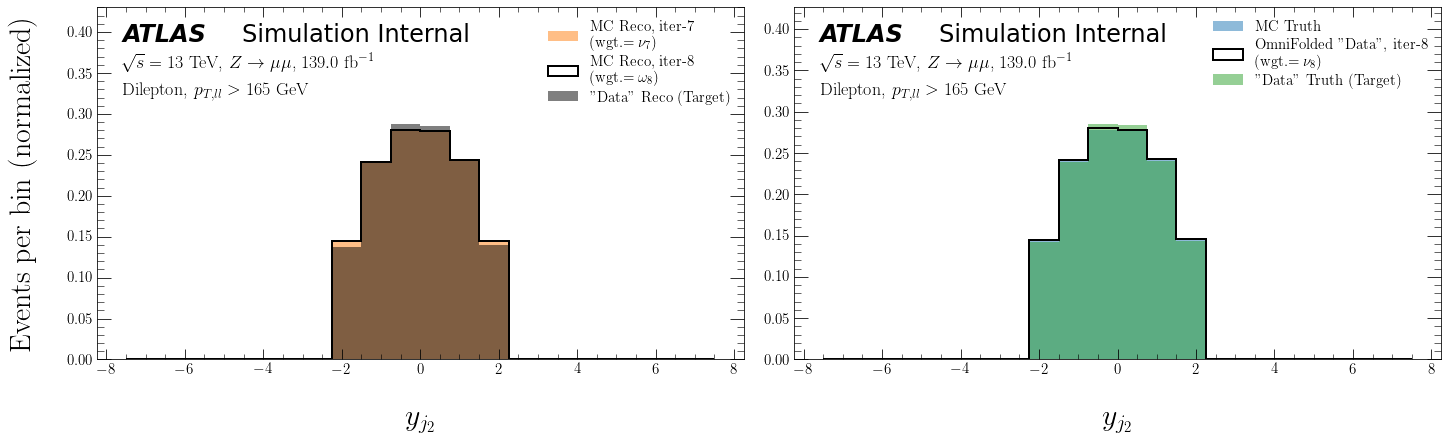

ITERATION 9:


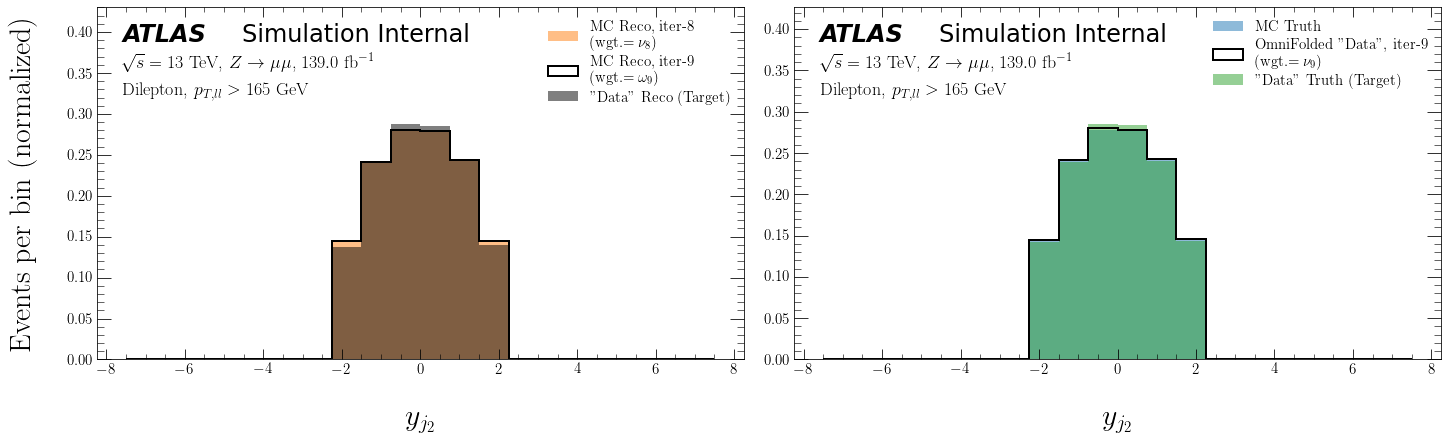

ITERATION 10:


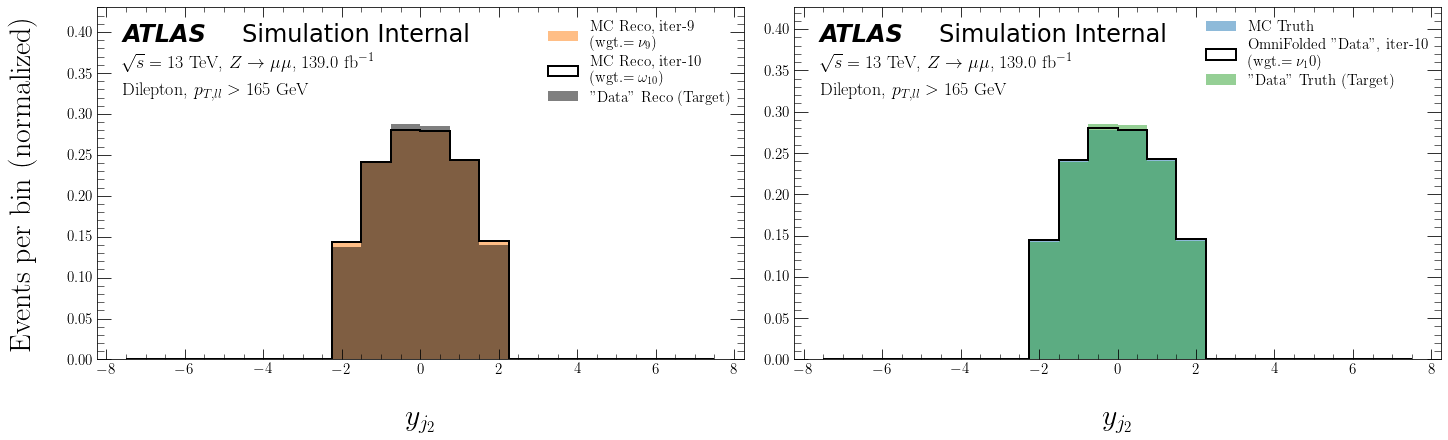

tau3_trackj2 Results

ITERATION 1:


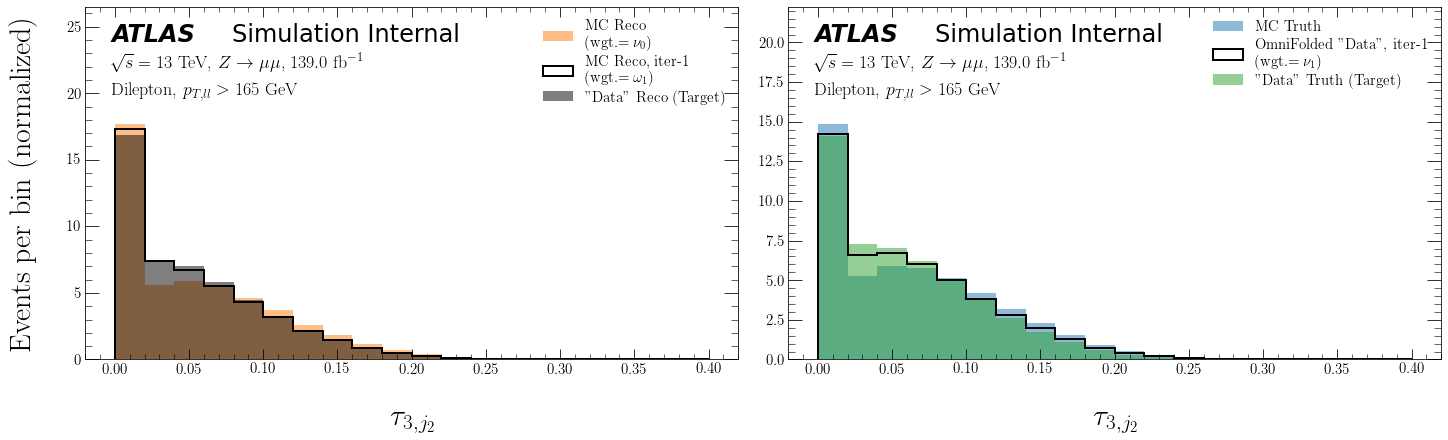

ITERATION 2:


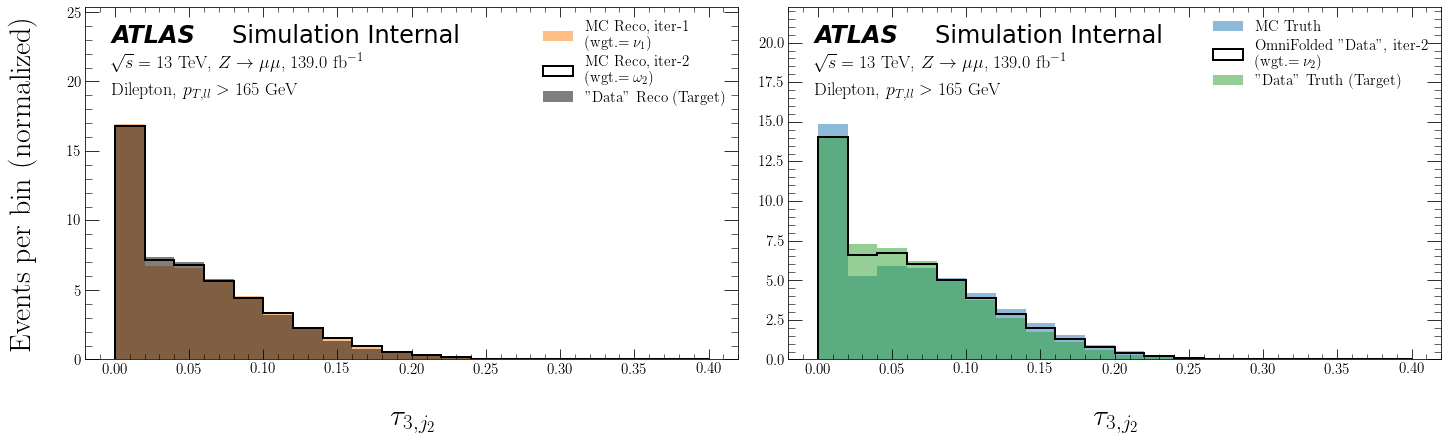

ITERATION 3:


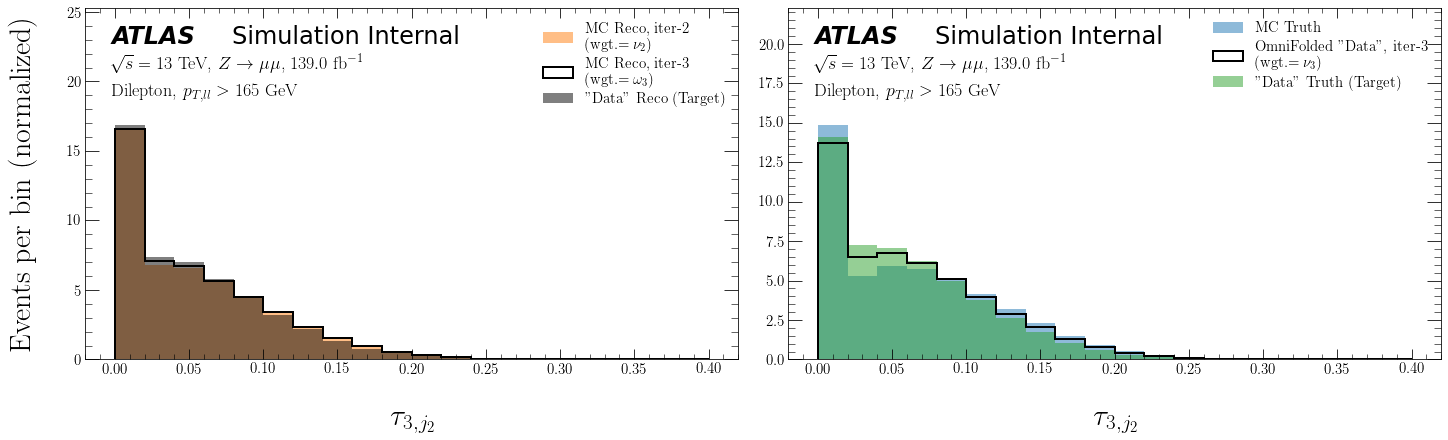

ITERATION 4:


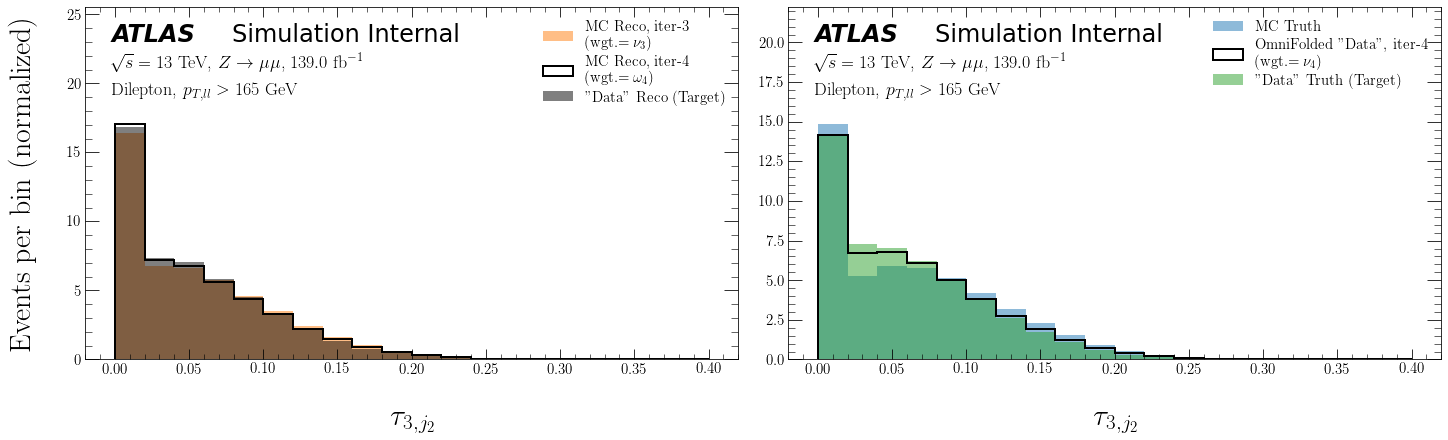

ITERATION 5:


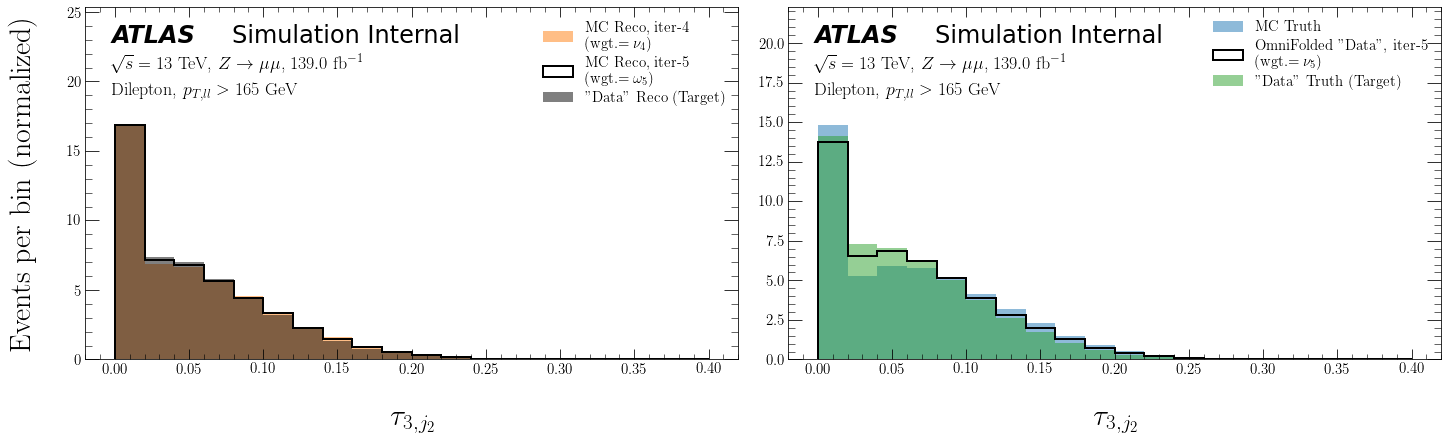

ITERATION 6:


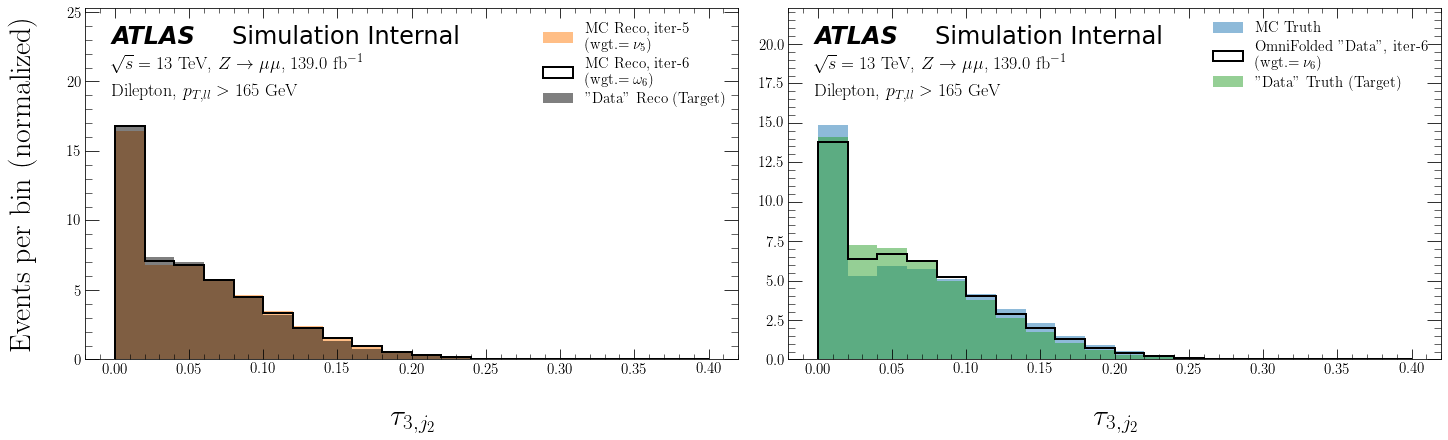

ITERATION 7:


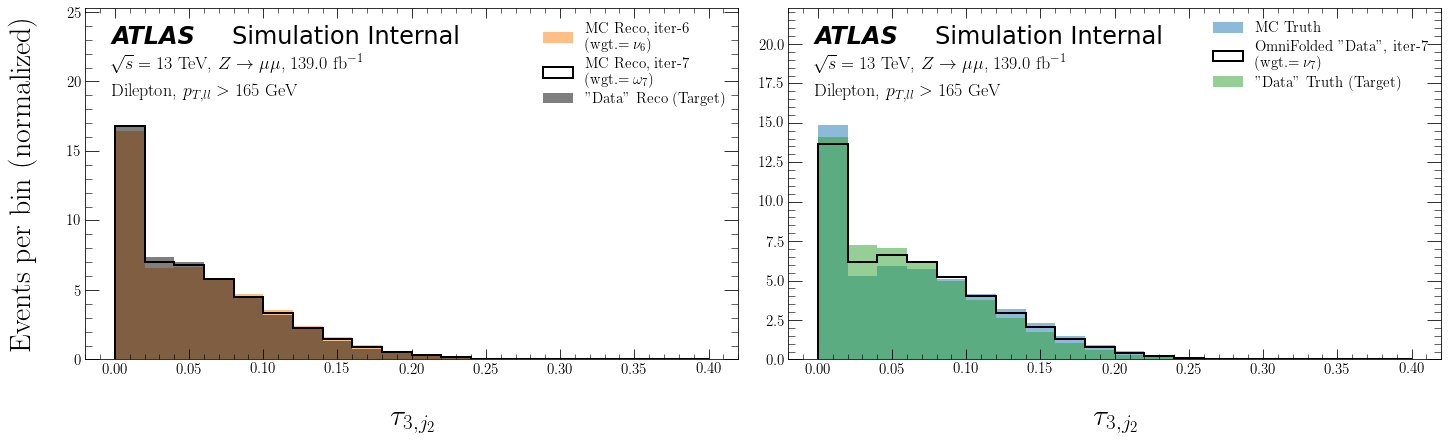

ITERATION 8:


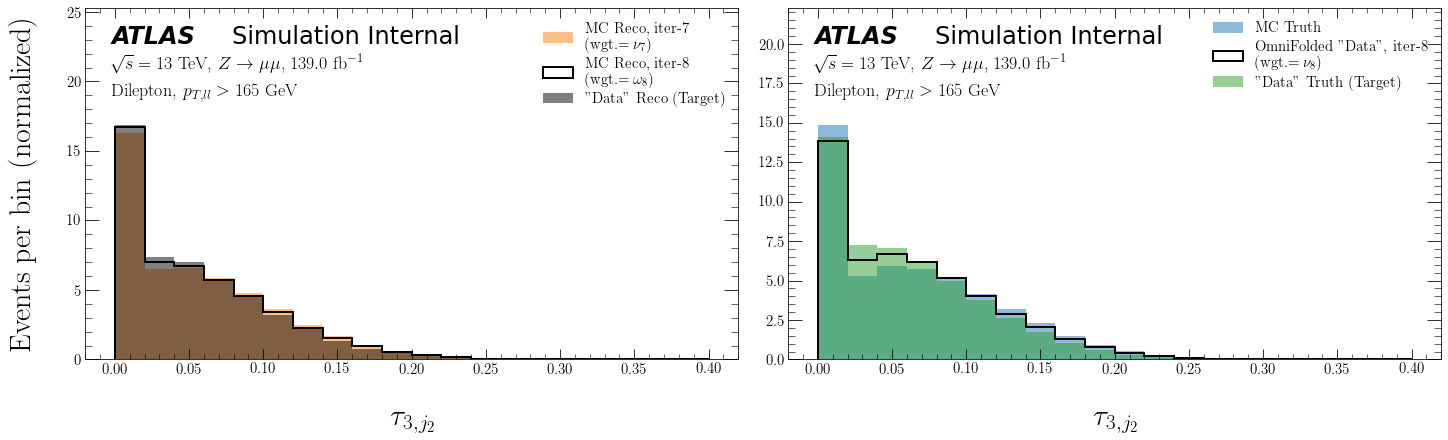

ITERATION 9:


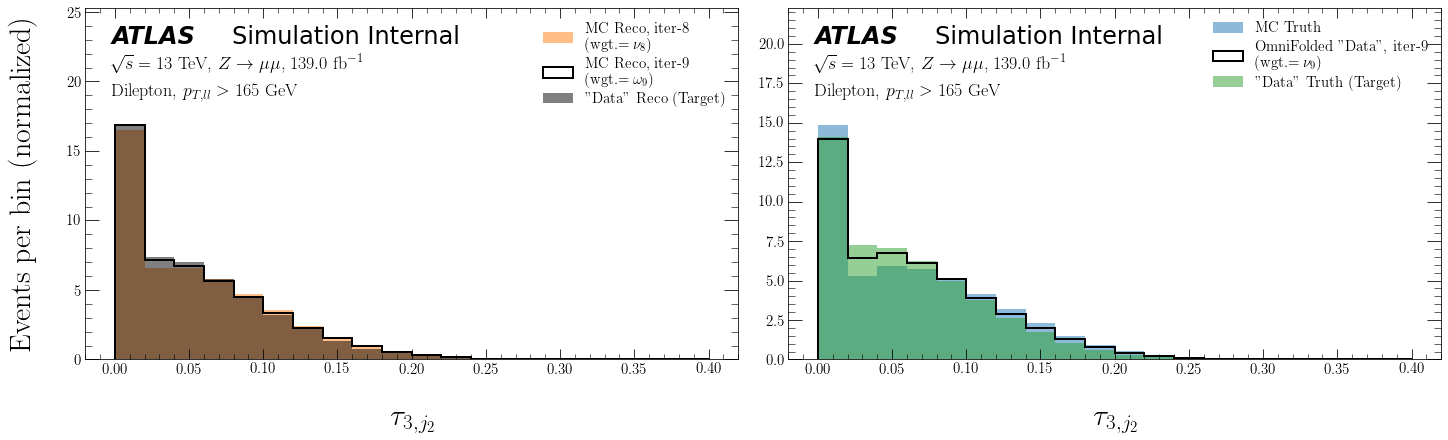

ITERATION 10:


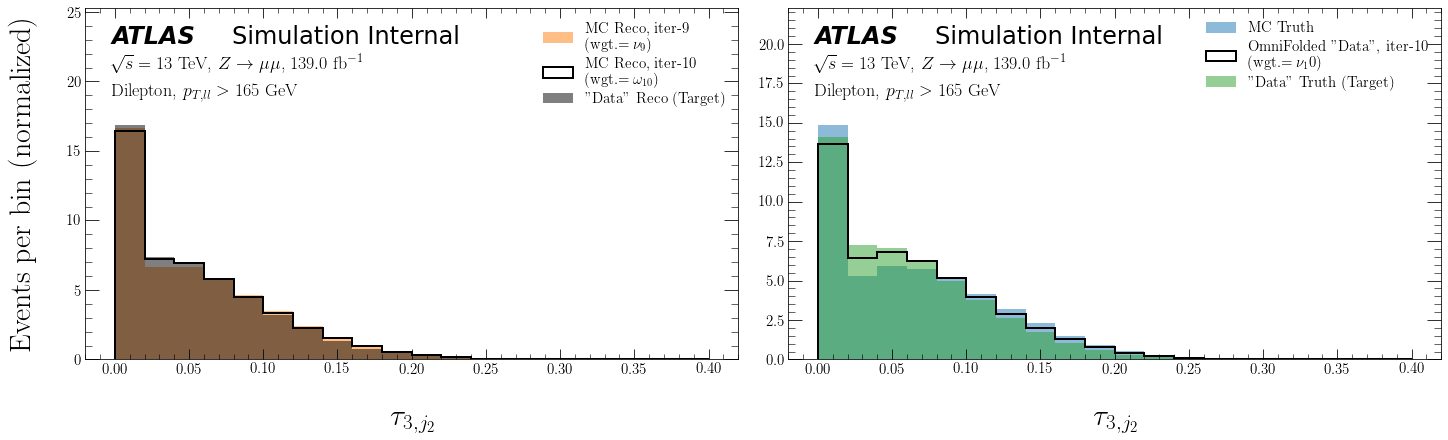

In [52]:
for i in range(len(obs_index)):
    print(obs[obs_index[i]]['file_label'] + " Results\n")
    bins = obs[obs_index[i]]['bins']
    x_label = obs[obs_index[i]]['plot_label']
    file_label = obs[obs_index[i]]['file_label']
    save_label = plot_dir + '/OmniFold/' + file_label + '/' + save_label0 + '-OmniFold-' + file_label

    plot_results(sim_truth=sim_truth_obs[i],
                 sim_reco=sim_reco_obs[i],
                 sim_weights_MC=sim_weights_MC,
                 data_truth=data_truth_obs[i],
                 data_reco=data_reco_obs[i],
                 data_weights_MC=data_weights_MC,
                 weights=weights,
                 bins=bins,
                 x_label=x_label)#,
                 #save_label=save_label)